<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2981]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## 1.1 Data Cleaning & Feature Engineering

In [2982]:
# Load the data
house = pd.read_csv('./housing.csv')

In [2983]:
# look at the shape of the dataset
house.shape

(1460, 81)

In [2984]:
# look at the dataset
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [2985]:
# print all column names
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [2986]:
# drop id - this is not a useful column
house.drop('Id',axis = 1, inplace = True)

In [2987]:
# investigate which properties are not residential
house['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [2988]:
# remove the commerical properties from the dataset
house = house[(house['MSZoning'] != 'C (all)')]

In [2989]:
# count the missing values for each column
count_na = house.isna().sum()
# display only the columns which have missing values
count_na[count_na != 0]

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64

In [2990]:
# Find which values correlate most strongly with LotFrontage in order to impute the missing values
for x, y in house.corr().items():
    if x == 'LotFrontage':
        df = pd.DataFrame({'variable':y.index, 'correlation': abs(y.values)})

df.sort_values(by = 'correlation', ascending = False).head()

variable  correlation
1   LotFrontage     1.000000
12     1stFlrSF     0.459003
2       LotArea     0.425810
15    GrLivArea     0.405956
11  TotalBsmtSF     0.392776

In [2991]:
# Use knn imputer to impute the missing values for LotFrontage based on 1stFlrSF
# Thanks to Lewis for the suggestion!!

# Import knnimputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
house[['1stFlrSF', 'LotFrontage']] = imputer.fit_transform(house[['1stFlrSF', 'LotFrontage']])

In [2992]:
# For values where NA means none (e.g. garage type = no garage) - convert NA to none
house[['Alley','GarageType','Fence','MiscFeature']] = house[['Alley','GarageType',
                                                             'Fence','MiscFeature']].fillna('None')

In [2993]:
# drop rows for cases where data appears to be genuinely missing and rows account for < 5% of data
house.dropna(subset= ['MasVnrType', 'MasVnrArea','Electrical'] , inplace = True)

In [2994]:
# For ordinal variables - carry out ordinal encoding (higher quality = higher value)
# https://www.kdnuggets.com/2021/05/deal-with-categorical-data-machine-learning.html
# note: if the house does not have the feature this will be assigned a value of 0
# e.g. for column: basequal, 'NA' means there is no basement - this will be assigned 0 

# Create a list of all quality variables (values = 'Ex', 'Gd', 'TA', 'Fa', 'PO', 'NA')
quality_variables = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC','KitchenQual',
                     'FireplaceQu','GarageQual','GarageCond','PoolQC']

# for each column map each value with a new encoded value
for col in quality_variables:
    house[col] = house[col].map({'Ex' : 5, 
                                 'Gd' : 4, 
                                 'TA' : 3, 
                                 'Fa' : 2, 
                                 'Po' : 1, 
                                 np.nan : 0})
    
# map basement exposure to encoded values 
house['BsmtExposure'] = house['BsmtExposure'].map({'Gd' : 4, 
                                                   'Av' : 3, 
                                                   'Mn' : 2, 
                                                   'No' : 1, 
                                                   np.nan : 0})

# map quality of finish to encoded values
finish_variables =['BsmtFinType1','BsmtFinType2']
for col in finish_variables:
    house[col] = house[col].map({'GLQ' : 6, 
                                 'ALQ' : 5, 
                                 'BLQ' : 4, 
                                 'Rec' : 3, 
                                 'LwQ' : 2, 
                                 'Unf': 1, 
                                 np.nan : 0})

# map garage finish to encoded values
house['GarageFinish'] = house['GarageFinish'].map({'Fin' : 3, 
                                                   'RFn' : 2, 
                                                   'Unf' : 1, 
                                                   np.nan : 0})
# map land slope to encoded values
house['LandSlope'] = house['LandSlope'].map({'Gtl' : 3, 
                                             'Mod' : 2,
                                             'Sev' : 1})

In [2995]:
# Create a list of variables where 0 refers to a non existent feature e.g. a pool
features = ['MasVnrArea', 'TotalBsmtSF', 'HeatingQC','Fireplaces','GarageArea', 
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
            'PoolArea', 'MiscVal']

# Determine the proportion of houses that do not have that feature
zero_count = [(house[x] == 0).sum() for x in features]
zero_proportion = [((house[x] == 0).sum()) / ((house[x].notna()).sum()) for x in features]

# Create a dataframe of the proportions
zeros = pd.DataFrame({'feature' : features, 'zero_count' : zero_count, 'zero_proportion' : zero_proportion})
zeros.sort_values(by = 'zero_proportion', ascending = False)

feature  zero_count  zero_proportion
10       PoolArea        1434         0.995142
8       3SsnPorch        1417         0.983345
11        MiscVal        1391         0.965302
9     ScreenPorch        1326         0.920194
7   EnclosedPorch        1240         0.860514
0      MasVnrArea         850         0.589868
5      WoodDeckSF         747         0.518390
3      Fireplaces         676         0.469119
6     OpenPorchSF         647         0.448994
4      GarageArea          79         0.054823
1     TotalBsmtSF          37         0.025677
2       HeatingQC           0         0.000000

In [2996]:
# There are only 7 houses with a pool - this is probably unlikely to be a good predictor
# Drop all columns referring to pools
house.drop(columns = [x for x in house.columns if 'Pool' in x], inplace = True)

In [2997]:
# Check whether there are any object parameters which should be encoded as a float/int
house.dtypes[house.dtypes == 'object']

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
Foundation       object
Heating          object
CentralAir       object
Electrical       object
Functional       object
GarageType       object
PavedDrive       object
Fence            object
MiscFeature      object
SaleType         object
SaleCondition    object
dtype: object

In [2998]:
# Look at overview of numerical data
pd.set_option('display.max_columns', None)
house.describe()

MSSubClass  LotFrontage        LotArea    LandSlope  OverallQual  \
count  1441.000000  1441.000000    1441.000000  1441.000000  1441.000000   
mean     56.939625    70.531922   10514.793199     2.938931     6.108952   
std      42.314987    23.014089   10024.151521     0.274654     1.371307   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    60.000000    7535.000000     3.000000     5.000000   
50%      50.000000    70.000000    9492.000000     3.000000     6.000000   
75%      70.000000    80.000000   11606.000000     3.000000     7.000000   
max     190.000000   313.000000  215245.000000     3.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea    ExterQual  \
count  1441.000000  1441.000000   1441.000000  1441.000000  1441.000000   
mean      5.586398  1971.418459   1984.944483   104.476752     3.396947   
std       1.107893    30.010677     20.558682   181.528681     0.570664   
min       1.000000  1872.000000   1950.000000     0.000000     2.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     3.000000   
50%       5.000000  1973.000000   1994.000000     0.000000     3.000000   
75%       6.000000  2000.000000   2004.000000   167.000000     4.000000   
max       9.000000  2010.000000   2010.000000  1600.000000     5.000000   

         ExterCond     BsmtQual     BsmtCond  BsmtExposure  BsmtFinType1  \
count  1441.000000  1441.000000  1441.000000   1441.000000   1441.000000   
mean      3.085357     3.489244     2.934768      1.632200      3.554476   
std       0.350100     0.879585     0.553943      1.069484      2.106863   
min       1.000000     0.000000     0.000000      0.000000      0.000000   
25%       3.000000     3.000000     3.000000      1.000000      1.000000   
50%       3.000000     4.000000     3.000000      1.000000      4.000000   
75%       3.000000     4.000000     3.000000      2.000000      6.000000   
max       5.000000     5.000000     4.000000      4.000000      6.000000   

        BsmtFinSF1  BsmtFinType2   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF  \
count  1441.000000   1441.000000  1441.000000  1441.000000  1441.000000   
mean    443.798057      1.250520    47.163081   567.333102  1058.294240   
std     455.626599      0.897745   162.290824   442.933526   438.420249   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%       0.000000      1.000000     0.000000   221.000000   796.000000   
50%     384.000000      1.000000     0.000000   476.000000   992.000000   
75%     712.000000      1.000000     0.000000   808.000000  1300.000000   
max    5644.000000      6.000000  1474.000000  2336.000000  6110.000000   

         HeatingQC     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
count  1441.000000  1441.000000  1441.000000   1441.000000  1441.000000   
mean      4.147120  1163.703678   347.145038      5.565579  1516.414296   
std       0.959894   385.056495   437.022445     47.077360   525.479240   
min       1.000000   334.000000     0.000000      0.000000   334.000000   
25%       3.000000   884.000000     0.000000      0.000000  1130.000000   
50%       5.000000  1088.000000     0.000000      0.000000  1466.000000   
75%       5.000000  1392.000000   728.000000      0.000000  1776.000000   
max       5.000000  4692.000000  2065.000000    572.000000  5642.000000   

       BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  \
count   1441.000000   1441.000000  1441.000000  1441.000000   1441.000000   
mean       0.426093      0.057599     1.566273     0.383067      2.870923   
std        0.519334      0.238949     0.548939     0.503148      0.813937   
min        0.000000      0.000000     0.000000     0.000000      0.000000   
25%        0.000000      0.000000     1.000000     0.000000      2.000000   
50%        0.000000      0.000000     2.000000     0.000000      3.000000   
75%        1.000000      0.000000     2.000000     1.000000      3.0000

In [2999]:
# look at overview of object type data
house.describe(include = 'object').sort_values(by = 'freq', ascending = False, axis = 1)

Utilities Street Condition2 RoofMatl Heating MiscFeature Alley  \
count       1441   1441       1441     1441    1441        1441  1441   
unique         2      2          8        8       6           5     3   
top       AllPub   Pave       Norm  CompShg    GasA        None  None   
freq        1440   1437       1427     1415    1410        1389  1353   

       CentralAir Functional PavedDrive Electrical LandContour SaleType  \
count        1441       1441       1441       1441        1441     1441   
unique          2          7          3          5           4        9   
top             Y        Typ          Y      SBrkr         Lvl       WD   
freq         1352       1342       1326       1320        1296     1255   

       Condition1 BldgType SaleCondition Fence MSZoning RoofStyle LotConfig  \
count        1441     1441          1441  1441     1441      1441      1441   
unique          9        5             6     5        4         6         5   
top          Norm     1Fam        Normal  None       RL     Gable    Inside   
freq         1243     1203          1189  1163     1145      1127      1037   

       LotShape GarageType MasVnrType HouseStyle Foundation Exterior1st  \
count      1441       1441       1441       1441       1441        1441   
unique        4          7          4          8          6          15   
top         Reg     Attchd       None     1Story      PConc     VinylSd   
freq        909        863        853        717        638         509   

       Exterior2nd Neighborhood  
count         1441         1441  
unique          16           25  
top        VinylSd        NAmes  
freq           498          225

In [3000]:
# utilities and street only have 1 and 4 values which have different values to the rest respectively
# these columns will be dropped as the very low variability means they probably will not be good predictors
house.drop(columns = ['Utilities','Street'], inplace = True)

In [3001]:
# Investigate houses with 2 conditions - although there is very little variation shown in the .describe() table above
# there are also no NaNs meaning there may be repetition of Condition 1 in this column
house[['Condition1', 'Condition2']][house['Condition1'] == house['Condition2']]

Condition1 Condition2
0          Norm       Norm
2          Norm       Norm
3          Norm       Norm
4          Norm       Norm
5          Norm       Norm
...         ...        ...
1455       Norm       Norm
1456       Norm       Norm
1457       Norm       Norm
1458       Norm       Norm
1459       Norm       Norm

[1247 rows x 2 columns]

In [3002]:
# If condition 2 is the same as condition 1, map this to none as it is not actually a second condition
house.loc[house['Condition1'] == house['Condition2'], 'Condition2'] = 'None' 

In [3003]:
# Keep in this column for now, as we see more variation now the conditions are properly mapped
house['Condition2'].value_counts()

None     1247
Norm      184
Feedr       5
RRNn        2
PosA        1
RRAn        1
RRAe        1
Name: Condition2, dtype: int64

In [3004]:
# Investigate if the above is true for Exterior1st and Exterior2nd values
house[['Exterior1st','Exterior2nd']][house['Exterior1st'] == house['Exterior2nd']]

Exterior1st Exterior2nd
0        VinylSd     VinylSd
1        MetalSd     MetalSd
2        VinylSd     VinylSd
4        VinylSd     VinylSd
5        VinylSd     VinylSd
...          ...         ...
1454     VinylSd     VinylSd
1455     VinylSd     VinylSd
1456     Plywood     Plywood
1458     MetalSd     MetalSd
1459     HdBoard     HdBoard

[1229 rows x 2 columns]

In [3005]:
# From investigating the above, it was noticed there are some spelling discrepancies between Exterior1st & Exterior2nd
# Corrected spellings created from comparing to data description
incorrect_sp = ['Wd Shng', 'CmentBd', 'Brk Cmn']
correct_sp = ['WdShing', 'CemntBd', 'BrkComm']

# Spelling mistakes in Exterior2nd replaced
house['Exterior2nd'] = house['Exterior2nd'].replace(incorrect_sp, correct_sp)

In [3006]:
# If exterior2nd is the same as exterior1st, map this to none as it is not actually a second exterior
house.loc[house['Exterior1st'] == house['Exterior2nd'], 'Exterior2nd'] = 'None' 

In [3007]:
# If there were no rennovation YearRemodAdd is taken from YearBuilt. Check how many houses this is the case for
house[house['YearRemodAdd'] == house['YearBuilt']].shape[0]

758

In [3008]:
# As the YearRemodAdd is 50% a duplicate of YearBuilt - change column to RemodAdd (1 if yes, 0 if no)
remod_add = []
for index,row in house.iterrows():
    if row['YearBuilt'] == row['YearRemodAdd']:
        remod_add.append(0)
    else:
        remod_add.append(1)

house['RemodAdd'] = remod_add

In [3009]:
# Drop YearRemodAdd
house.drop('YearRemodAdd', axis = 1, inplace = True)

In [3010]:
# Create new features by combining other columns

# Add column of total bathrooms
house['TotalBath'] = house['FullBath'] + house['BsmtFullBath'] + 0.5*house['HalfBath'] + 0.5*house['BsmtHalfBath']

# Create a new column 'Age' (at point of sale - more precise when considering houses can be sold in different years)
house['Age'] = house['YrSold'] - house['YearBuilt']

In [3011]:
# Drop MSSubClass - this variable is just a combination of BldgType, HouseStyle & YrBuilt
house.drop(columns = ['MSSubClass'], inplace = True)

In [3012]:
# recheck remaining columns
house.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch

In [3013]:
# sort remaining columns into fixed variables and variables which can be rennovated before further analysis
# Sale price as the target variable will be included in both lists

fixed = ['MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
         'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
         'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'RemodAdd', 'Age', 
         'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
         'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotalBath', 'BedroomAbvGr',
         'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageType', 'GarageYrBlt', 'GarageCars',
         'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
         'MiscFeature', 'MiscVal', 'MoSold','YrSold', 'SaleType', 'SaleCondition', 'SalePrice']

# create a dataframe of the fixed variables
house_f = house[fixed].copy()

rennovate = ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
             'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
             'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 
             'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 
             'Electrical', 'LowQualFinSF', 'KitchenQual','Functional', 'Fireplaces', 
             'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',  
             'Fence', 'SalePrice']

# create a dataframe of the variables which can be rennovated
house_r = house[rennovate].copy()



In [3014]:
# look at the dimensions of the fixed characteristics database
house_f.shape

(1441, 47)

In [3015]:
# look at the dimensions of the rennovatable characteristics database
house_r.shape

(1441, 31)

## 1.2 EDA (fixed variables)

In [3016]:
# look at sale price distribution
house['SalePrice'].describe()

count      1441.000000
mean     181360.369188
std       79045.865429
min       37900.000000
25%      130000.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/Users/florascott/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


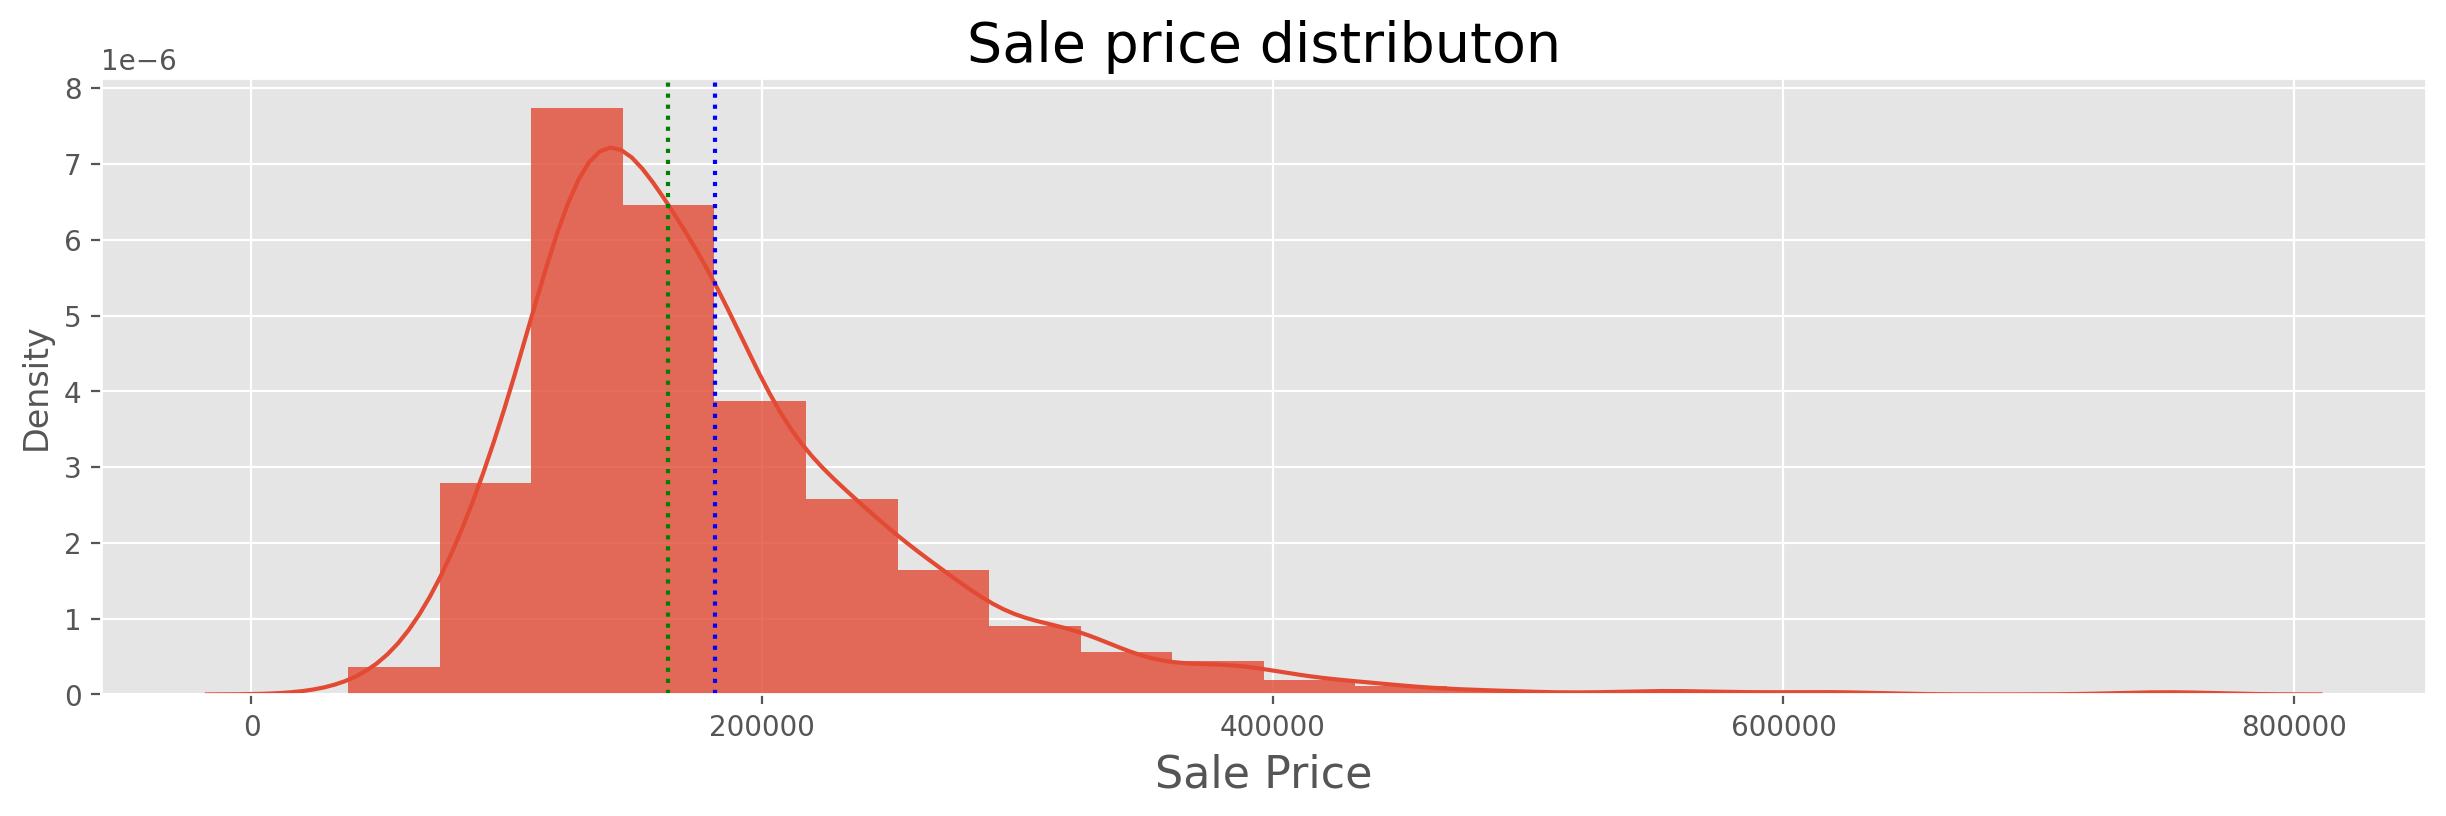

In [3017]:
# Plot the sale price distribution
fig, ax = plt.subplots(figsize=(15, 4))

sns.distplot(house['SalePrice'], bins=20, ax=ax, hist_kws={'alpha':0.8})
ax.set_xlabel('Sale Price', fontsize=16)
ax.set_title('Sale price distributon', fontsize=20)
ax.axvline(x= house['SalePrice'].mean(), color='blue', linestyle='dotted')
ax.axvline(x= house['SalePrice'].median(), color='green', linestyle='dotted')
plt.show()

In [3018]:
# Categorise variables 
nominal = ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
           'Condition2','BldgType', 'HouseStyle', 'RemodAdd', 'Foundation', 'GarageType', 'MiscFeature', 'MoSold',
           'SaleType', 'SaleCondition']
ordinal = ['LandSlope', 'BsmtExposure']
numerical = [x for x in house_f.columns if x not in nominal and x not in ordinal]

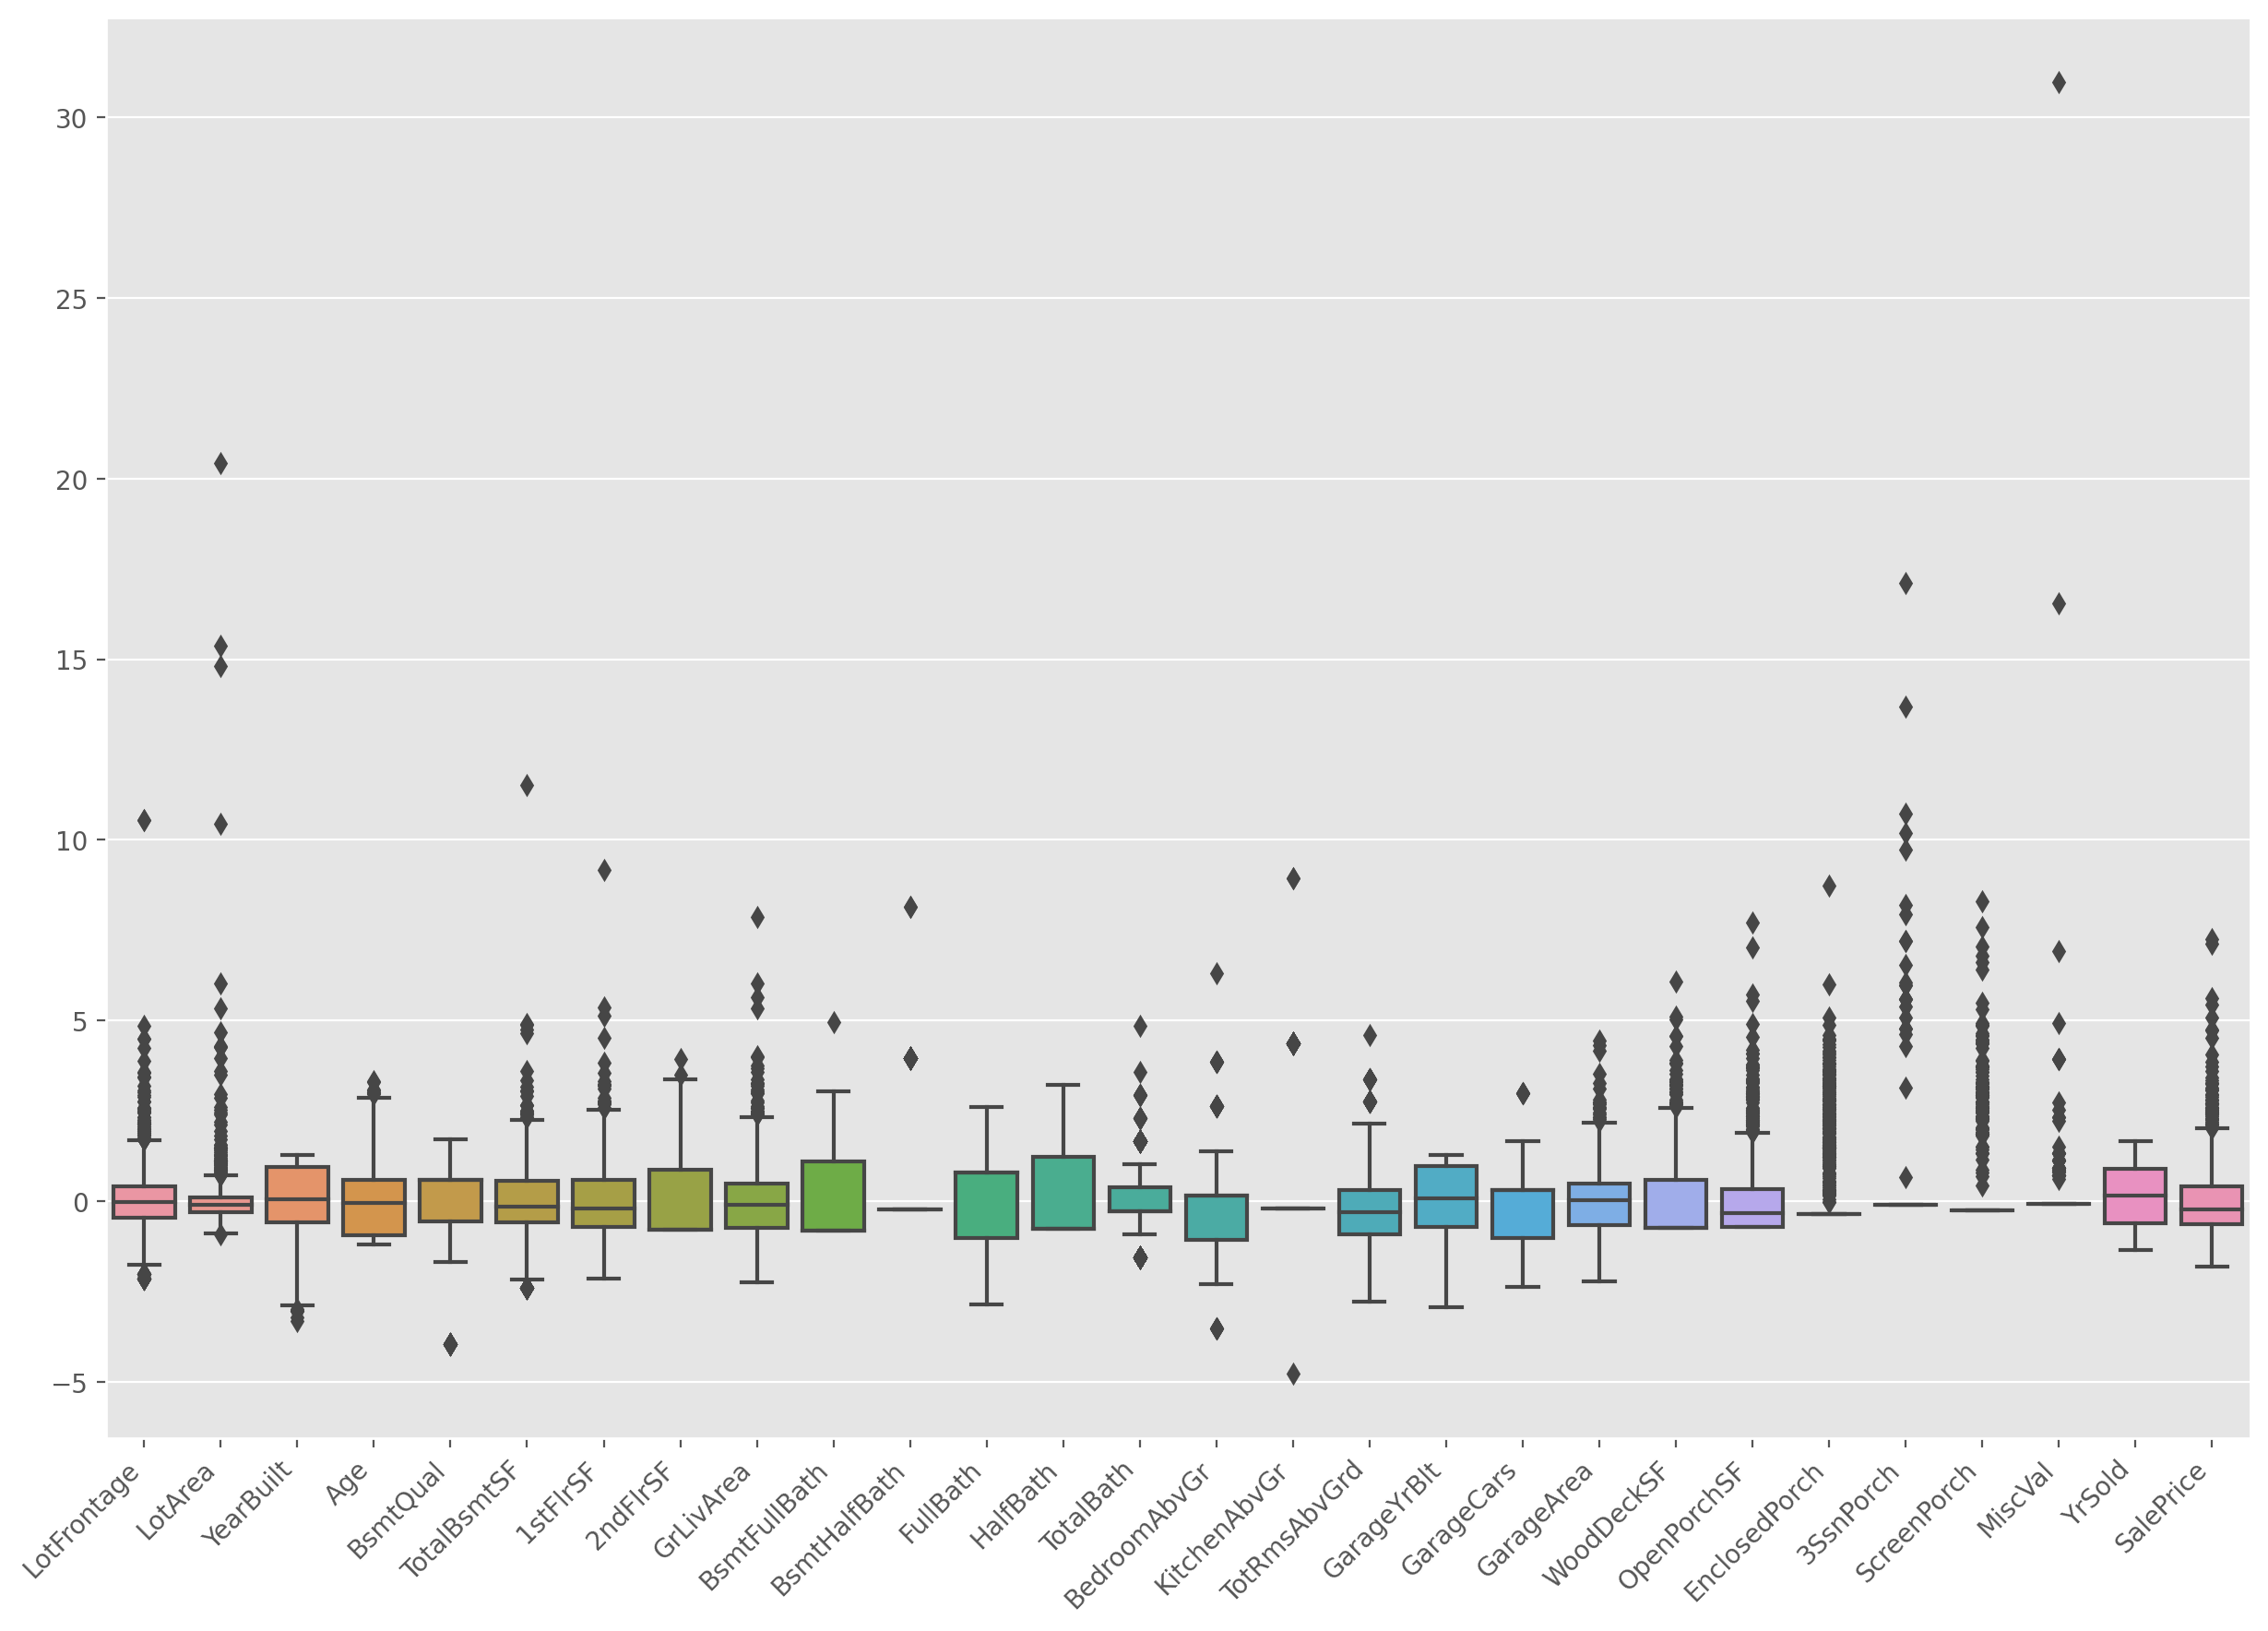

In [3019]:
# standaradise the numerical values
scaler = StandardScaler()
num_std = scaler.fit_transform(house_f[numerical])

# plot a boxplot of the standardised values  
fig, ax = plt.subplots(figsize = (15,10))

sns.boxplot(data= num_std)
ax.set_xticks([x for x in range(len(numerical))], labels = numerical, rotation = 45, horizontalalignment='right')
plt.show()

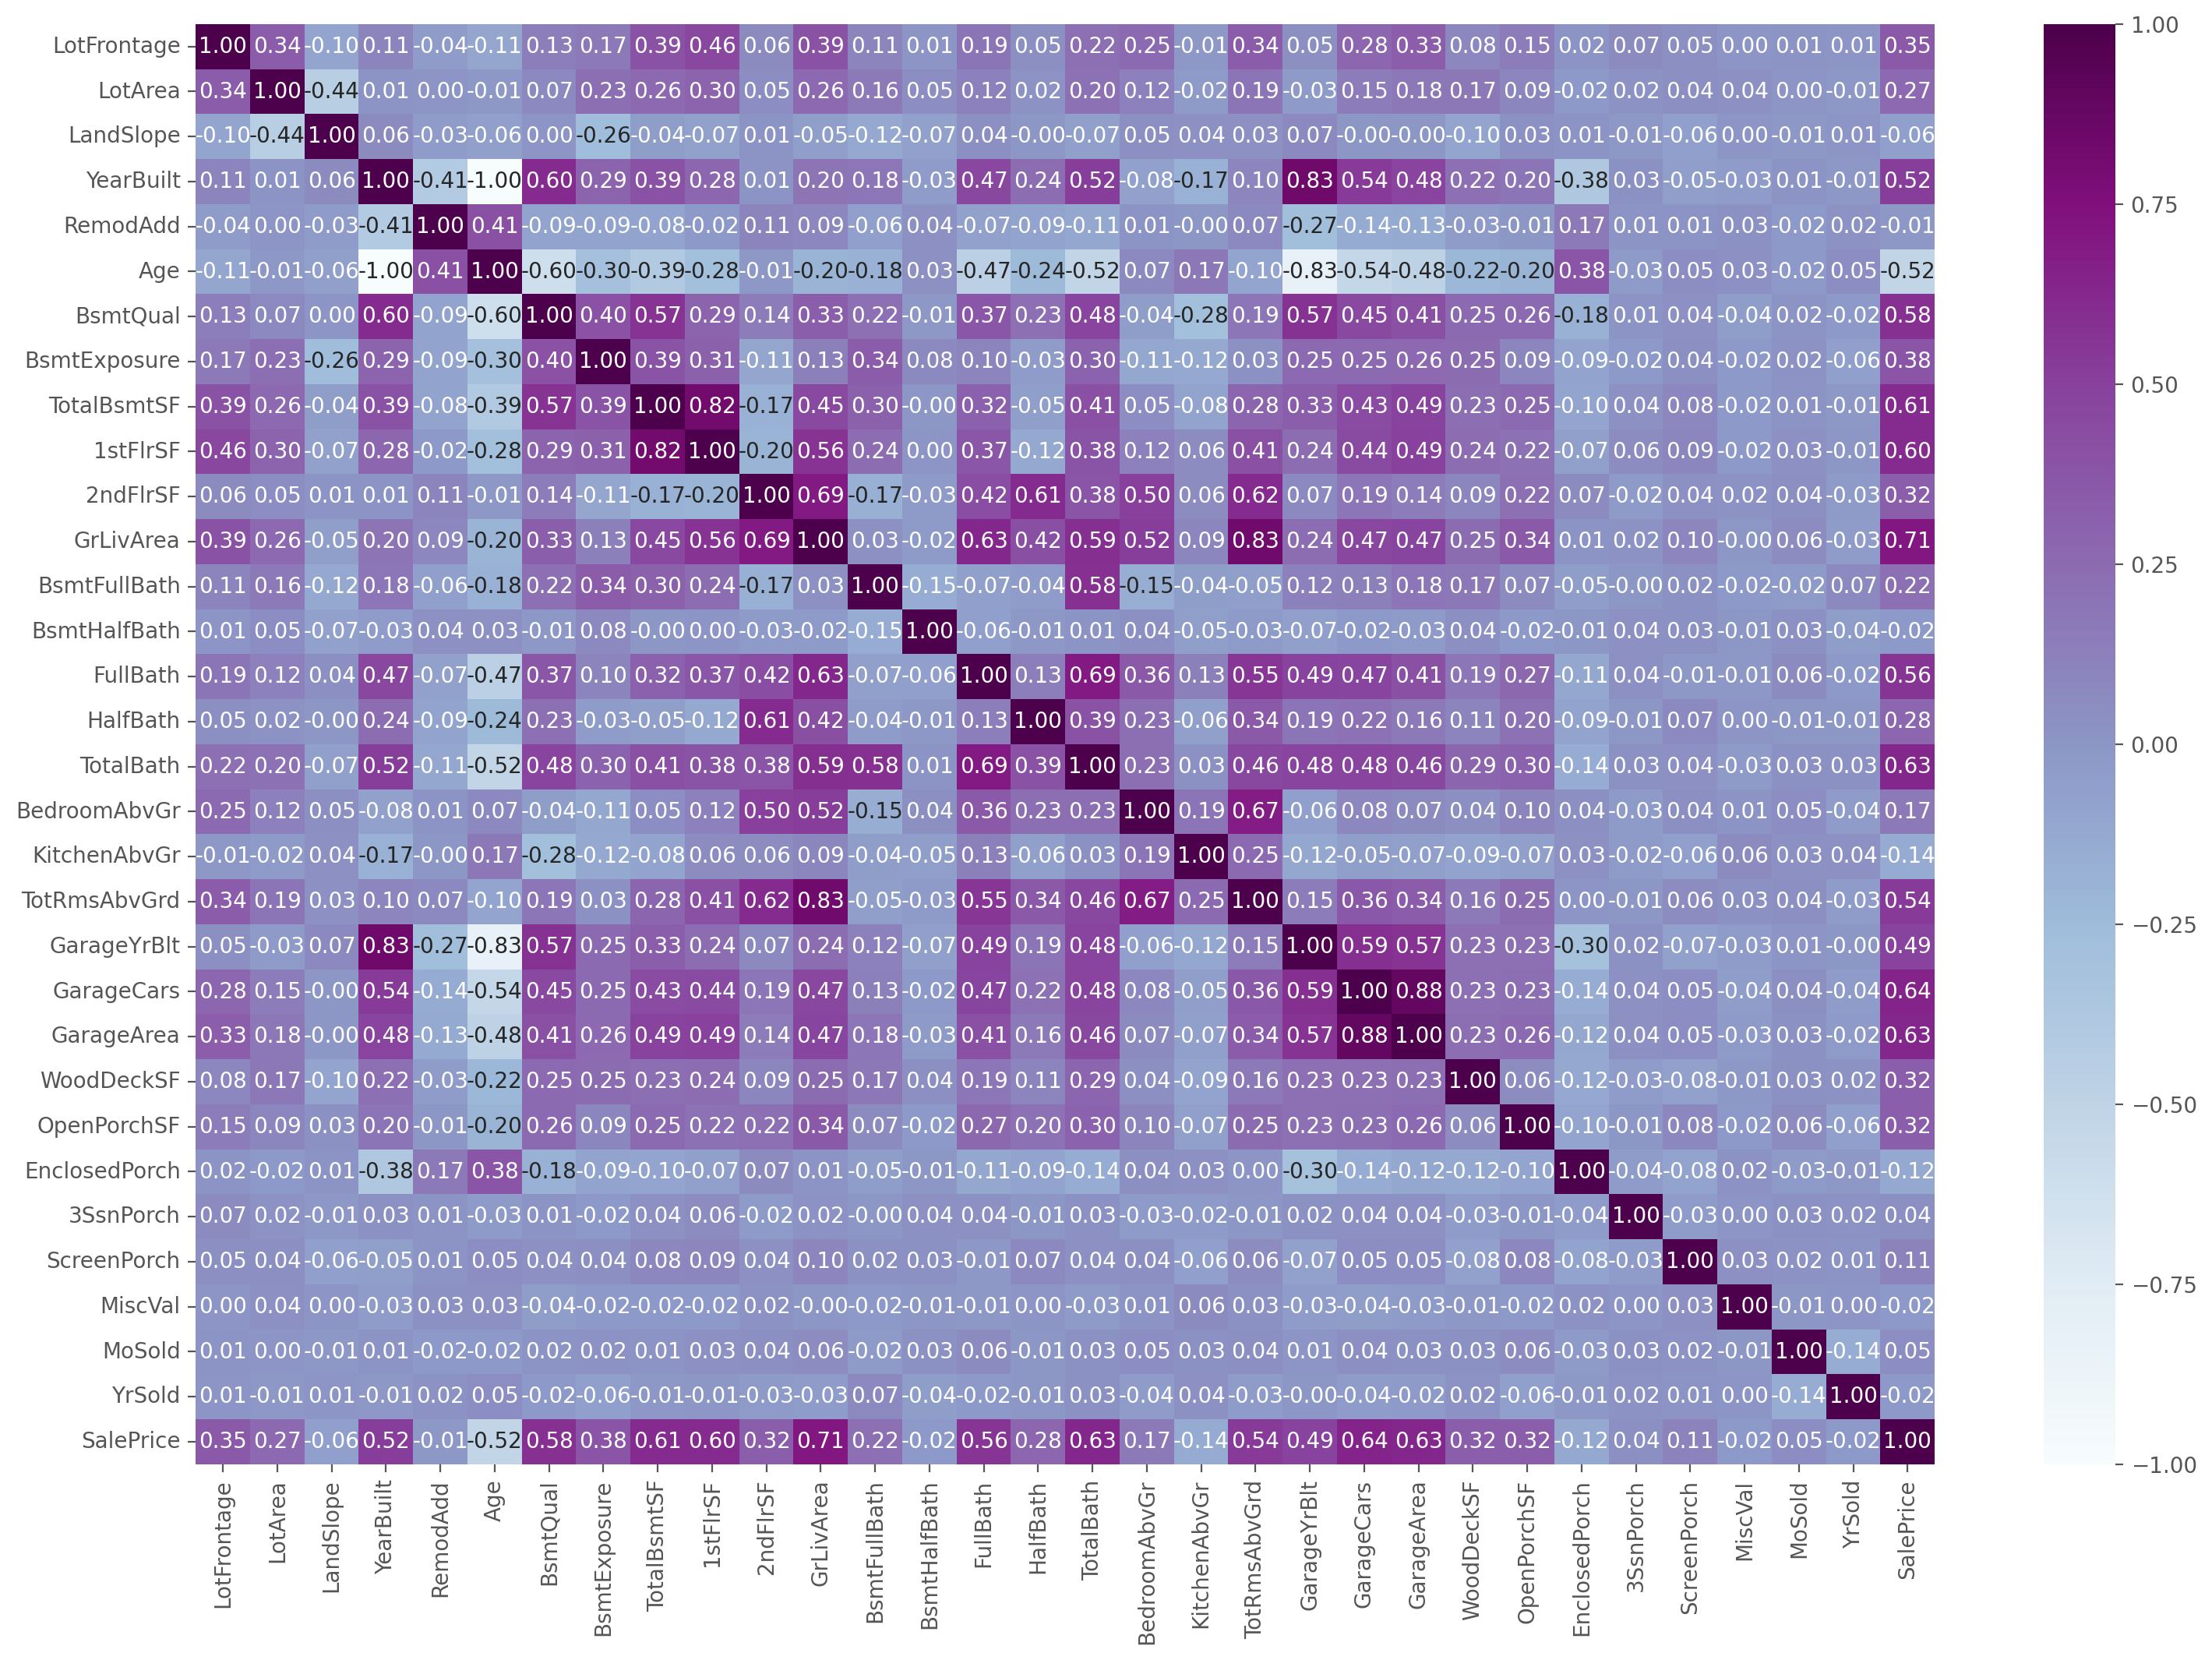

In [3020]:
# Create a correlation heat map for the fixed variables
corr_fixed = house_f.corr()

# plot a heat map of the correlation coefficients
fig, ax = plt.subplots(figsize = (18,12))
sns.heatmap(corr_fixed, cmap="BuPu", 
            annot = True, annot_kws= {'size' : 10}, fmt=".2f", 
            vmin = -1, vmax = 1, ax = ax)
plt.show()

In [3021]:
# Look at which values at most highly correlated with saleprice
for a,b in corr_fixed.items():
    if a == 'SalePrice':
        corr = pd.DataFrame({'variable':b.index, 'correlation':b.values})

corr['abs_corr'] = corr['correlation'].apply(lambda x: abs(x))        
corr.sort_values(by = 'abs_corr', ascending = False, inplace = True)
corr.reset_index(drop=True)

variable  correlation  abs_corr
0       SalePrice     1.000000  1.000000
1       GrLivArea     0.710134  0.710134
2      GarageCars     0.641491  0.641491
3      GarageArea     0.628906  0.628906
4       TotalBath     0.627546  0.627546
5     TotalBsmtSF     0.611801  0.611801
6        1stFlrSF     0.604408  0.604408
7        BsmtQual     0.583761  0.583761
8        FullBath     0.558744  0.558744
9    TotRmsAbvGrd     0.536023  0.536023
10            Age    -0.518244  0.518244
11      YearBuilt     0.517982  0.517982
12    GarageYrBlt     0.486393  0.486393
13   BsmtExposure     0.375984  0.375984
14    LotFrontage     0.348397  0.348397
15    OpenPorchSF     0.324932  0.324932
16       2ndFlrSF     0.323315  0.323315
17     WoodDeckSF     0.320991  0.320991
18       HalfBath     0.279096  0.279096
19        LotArea     0.265558  0.265558
20   BsmtFullBath     0.221909  0.221909
21   BedroomAbvGr     0.165747  0.165747
22   KitchenAbvGr    -0.139392  0.139392
23  EnclosedPorch    -0.120974  0.120974
24    ScreenPorch     0.112104  0.112104
25      LandSlope    -0.059979  0.059979
26         MoSold     0.050669  0.050669
27      3SsnPorch     0.044455  0.044455
28         YrSold    -0.022582  0.022582
29        MiscVal    -0.020827  0.020827
30   BsmtHalfBath    -0.016749  0.016749
31       RemodAdd    -0.011563  0.011563

In [3022]:
# Look for colinearity among other variables
feature1 = []
feature2 = []
corr = []
for a,b in corr_fixed.items():
    for x,y in b.items():
        if a != x:
            if abs(y) > 0.4:
                corr.append(round(abs(y),4))
                feature1.append(a)
                feature2.append(x)
highest_corr = pd.DataFrame({'feature_1': feature1, 'feature_2': feature2, 'correlation_abs' : corr})
highest_corr.drop_duplicates(subset='correlation_abs', inplace = True)
highest_corr.sort_values(by='correlation_abs',ascending = False).reset_index(drop=True)[:20]

feature_1     feature_2  correlation_abs
0      YearBuilt           Age           0.9990
1     GarageCars    GarageArea           0.8830
2      YearBuilt   GarageYrBlt           0.8285
3            Age   GarageYrBlt           0.8275
4      GrLivArea  TotRmsAbvGrd           0.8253
5    TotalBsmtSF      1stFlrSF           0.8177
6      GrLivArea     SalePrice           0.7101
7       FullBath     TotalBath           0.6907
8       2ndFlrSF     GrLivArea           0.6904
9   BedroomAbvGr  TotRmsAbvGrd           0.6745
10    GarageCars     SalePrice           0.6415
11    GarageArea     SalePrice           0.6289
12     TotalBath     SalePrice           0.6275
13     GrLivArea      FullBath           0.6268
14      2ndFlrSF  TotRmsAbvGrd           0.6168
15   TotalBsmtSF     SalePrice           0.6118
16      2ndFlrSF      HalfBath           0.6117
17      1stFlrSF     SalePrice           0.6044
18     YearBuilt      BsmtQual           0.6017
19   GarageYrBlt    GarageCars           0.5922

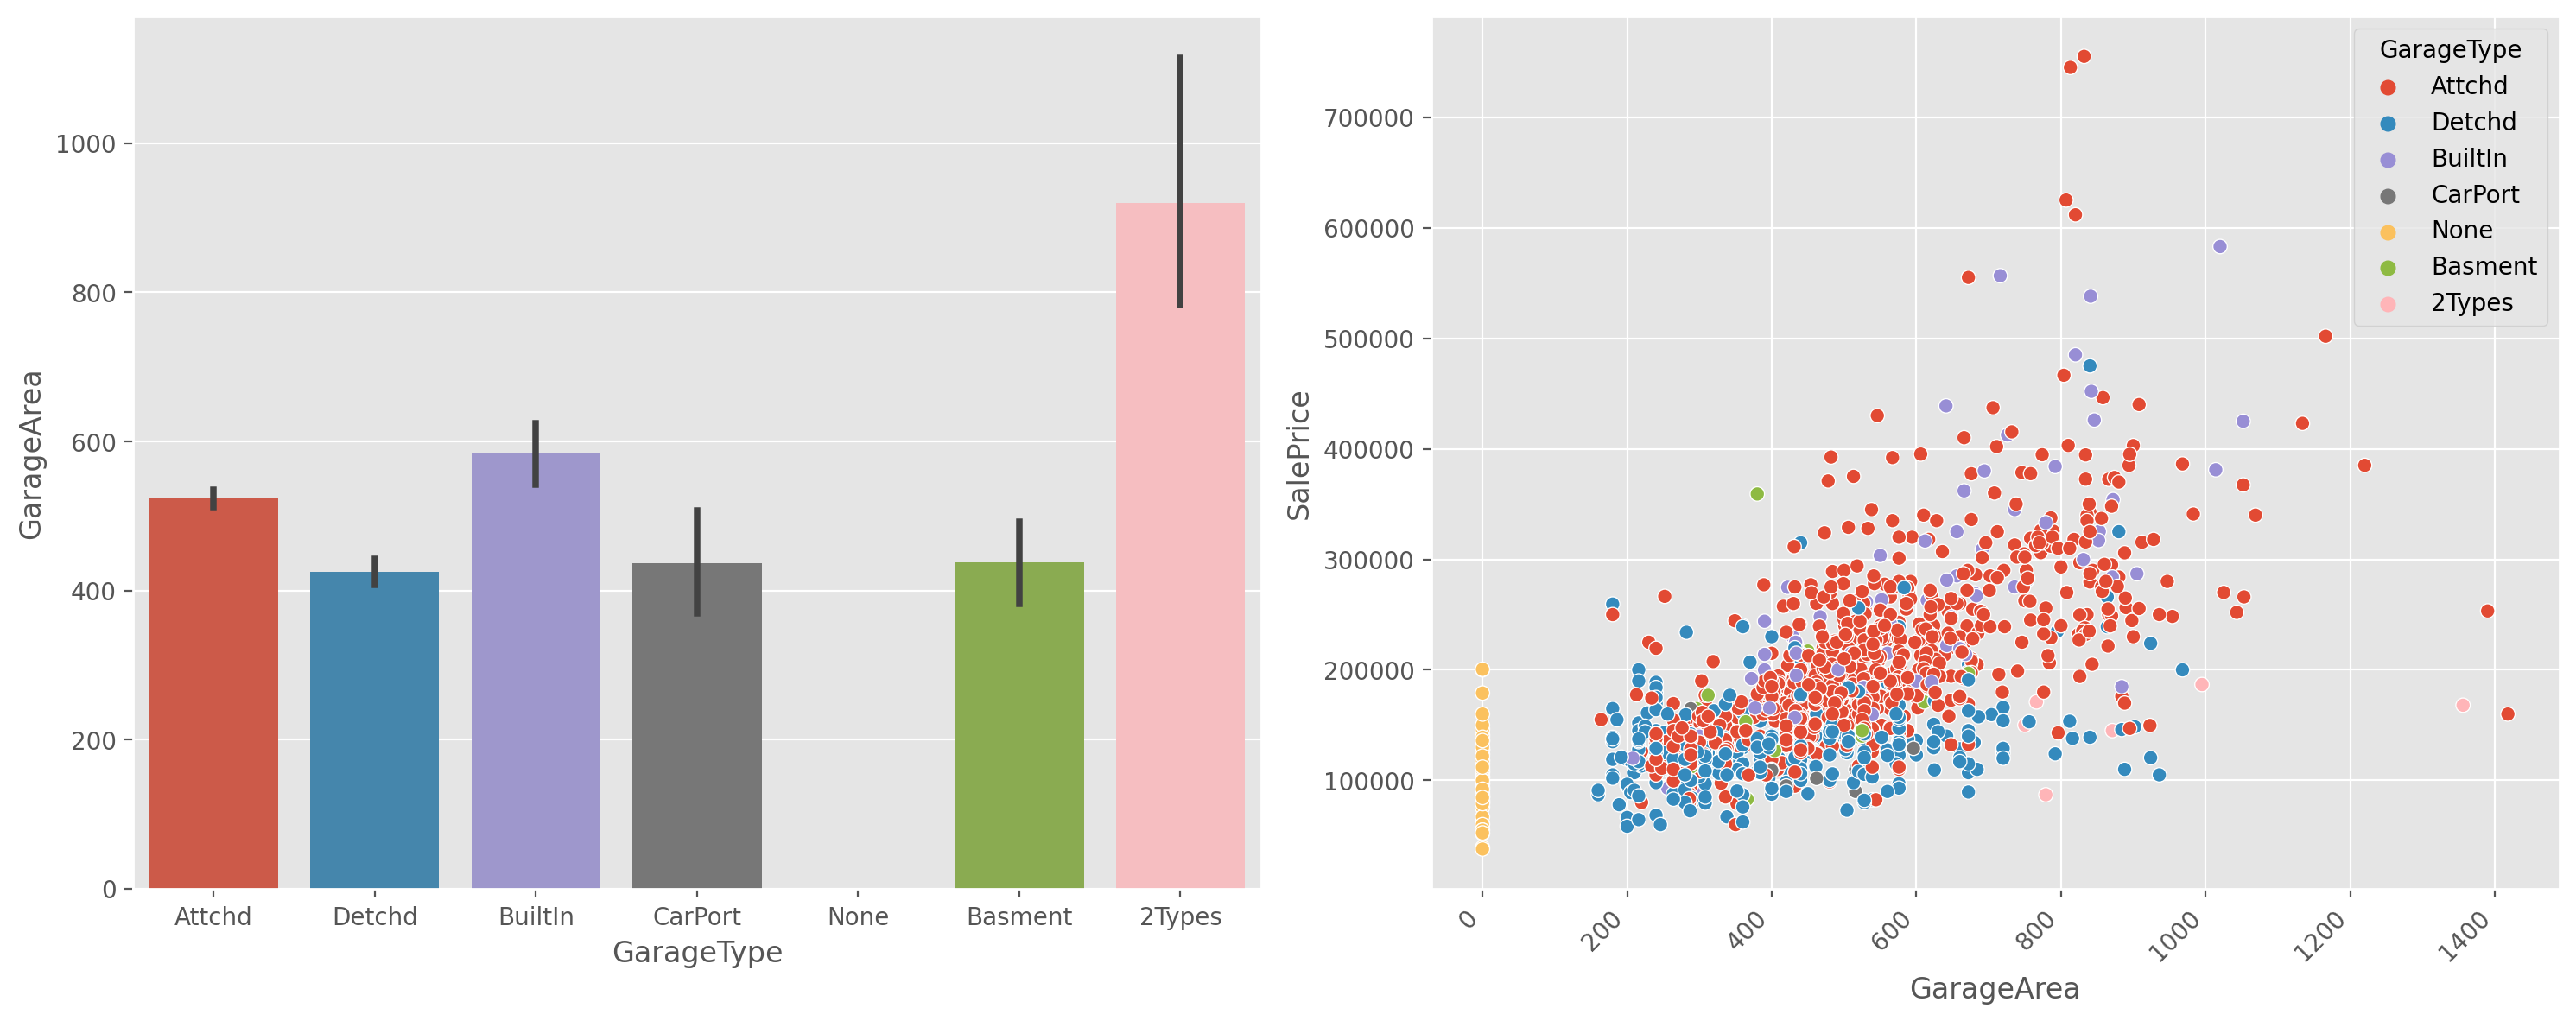

In [3023]:
# plot the median garage area for each garage type
fig, ax = plt.subplots(ncols = 2, figsize = (15,6))
plt.xticks(rotation = 45, horizontalalignment='right')
sns.barplot(data = house_f, x = 'GarageType', y = 'GarageArea', ax = ax[0])
sns.scatterplot(data = house_f, x = 'GarageArea', y = 'SalePrice', hue = 'GarageType', ax = ax[1])
plt.tight_layout()
plt.show()

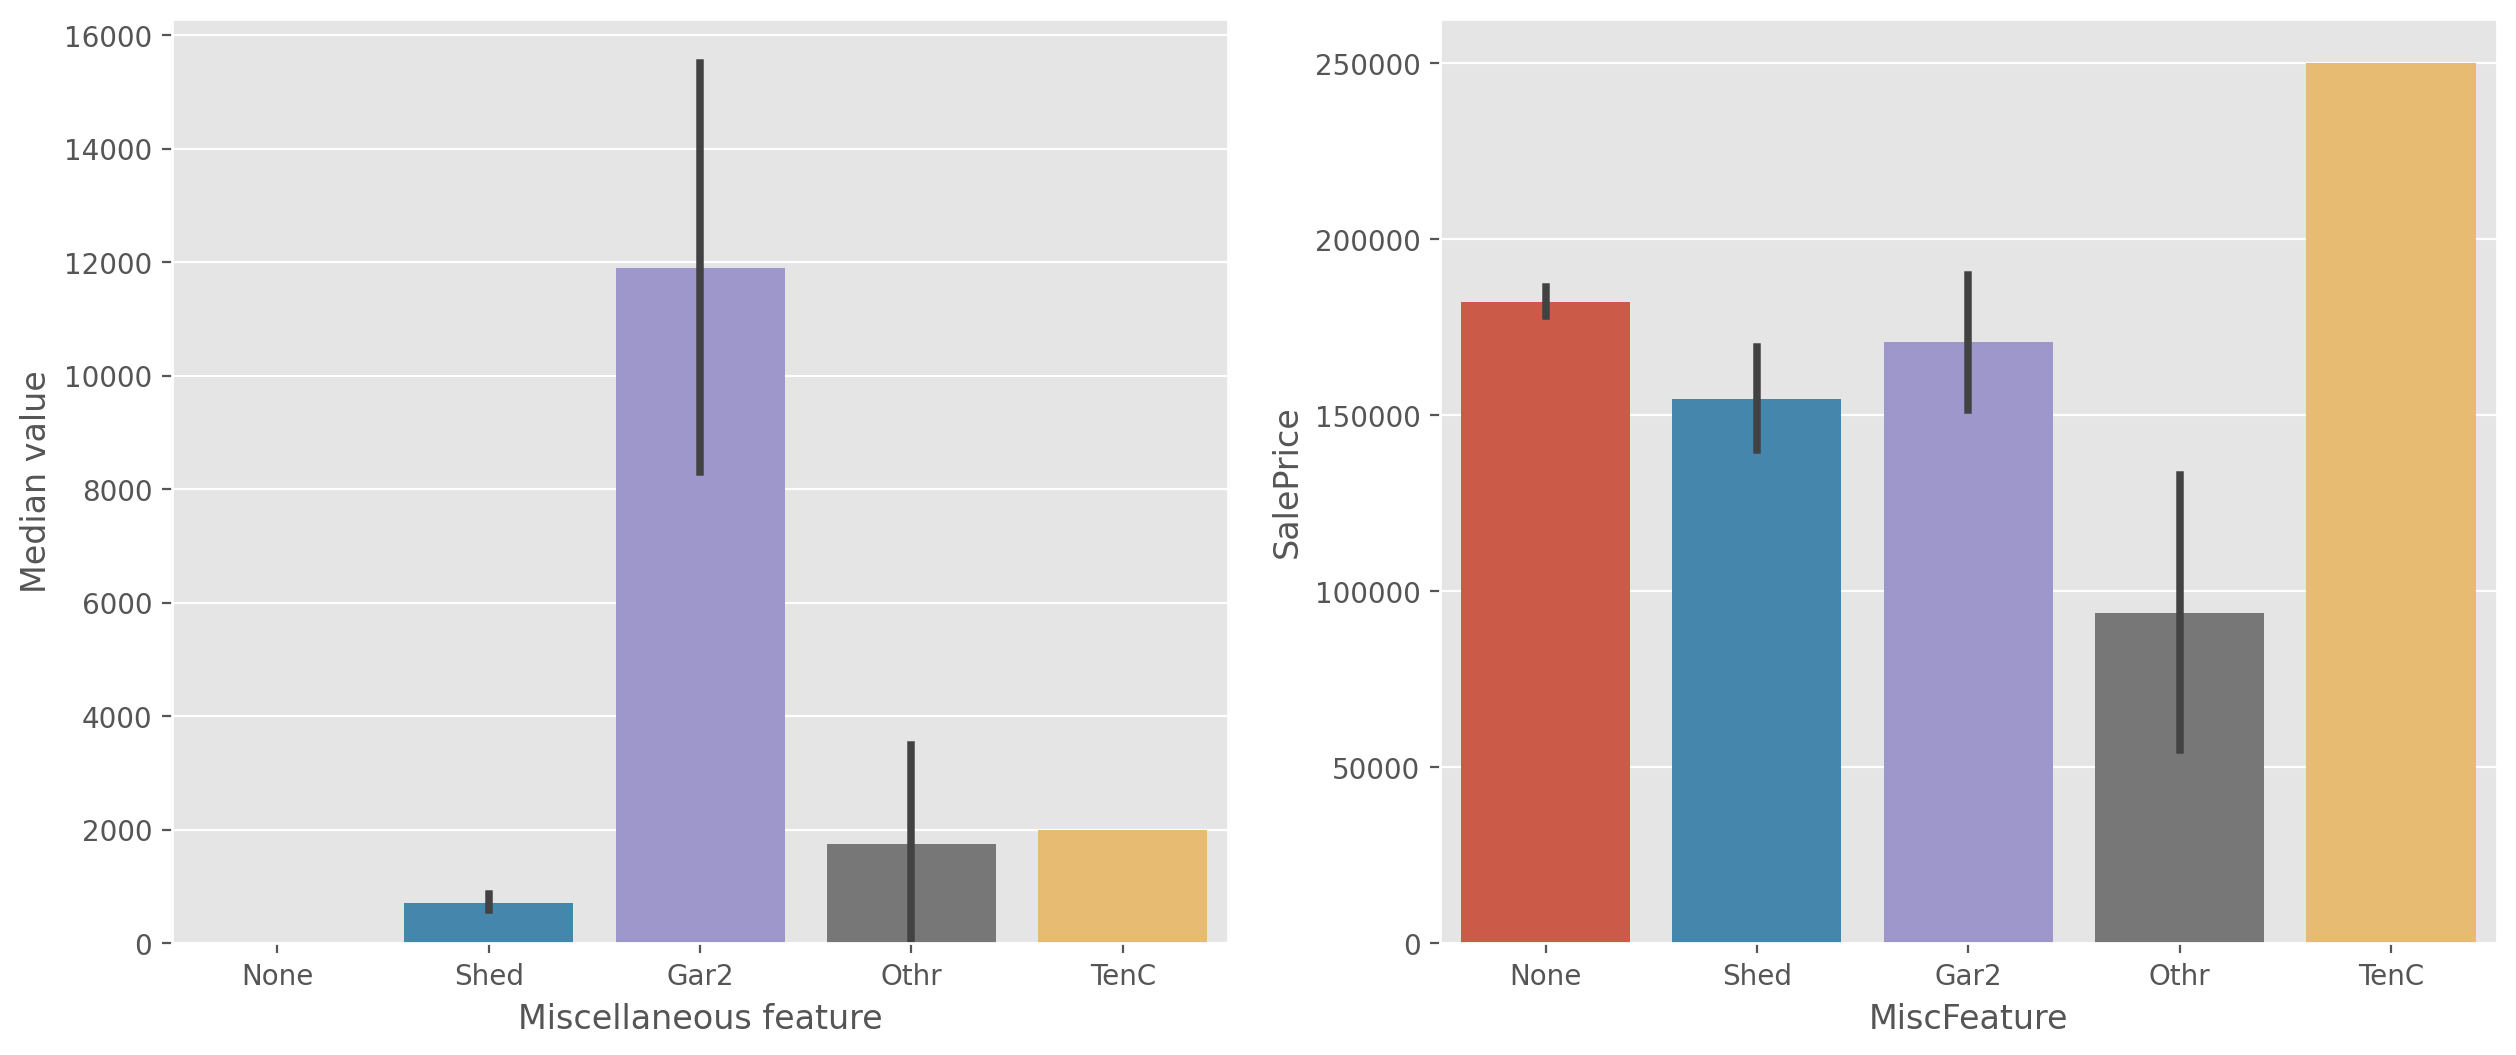

In [3024]:
# plot type of miscellaneous feature vs the median value of the miscellaneous feature and median sale price
fig, ax = plt.subplots(ncols = 2, figsize = (15,6))
sns.barplot(data= house_f, x= 'MiscFeature', y = 'MiscVal', ax = ax[0])
ax[0].set_xlabel('Miscellaneous feature')
ax[0].set_ylabel('Median value')

sns.barplot(data= house_f, x= 'MiscFeature', y = 'SalePrice', ax = ax[1])
plt.show()

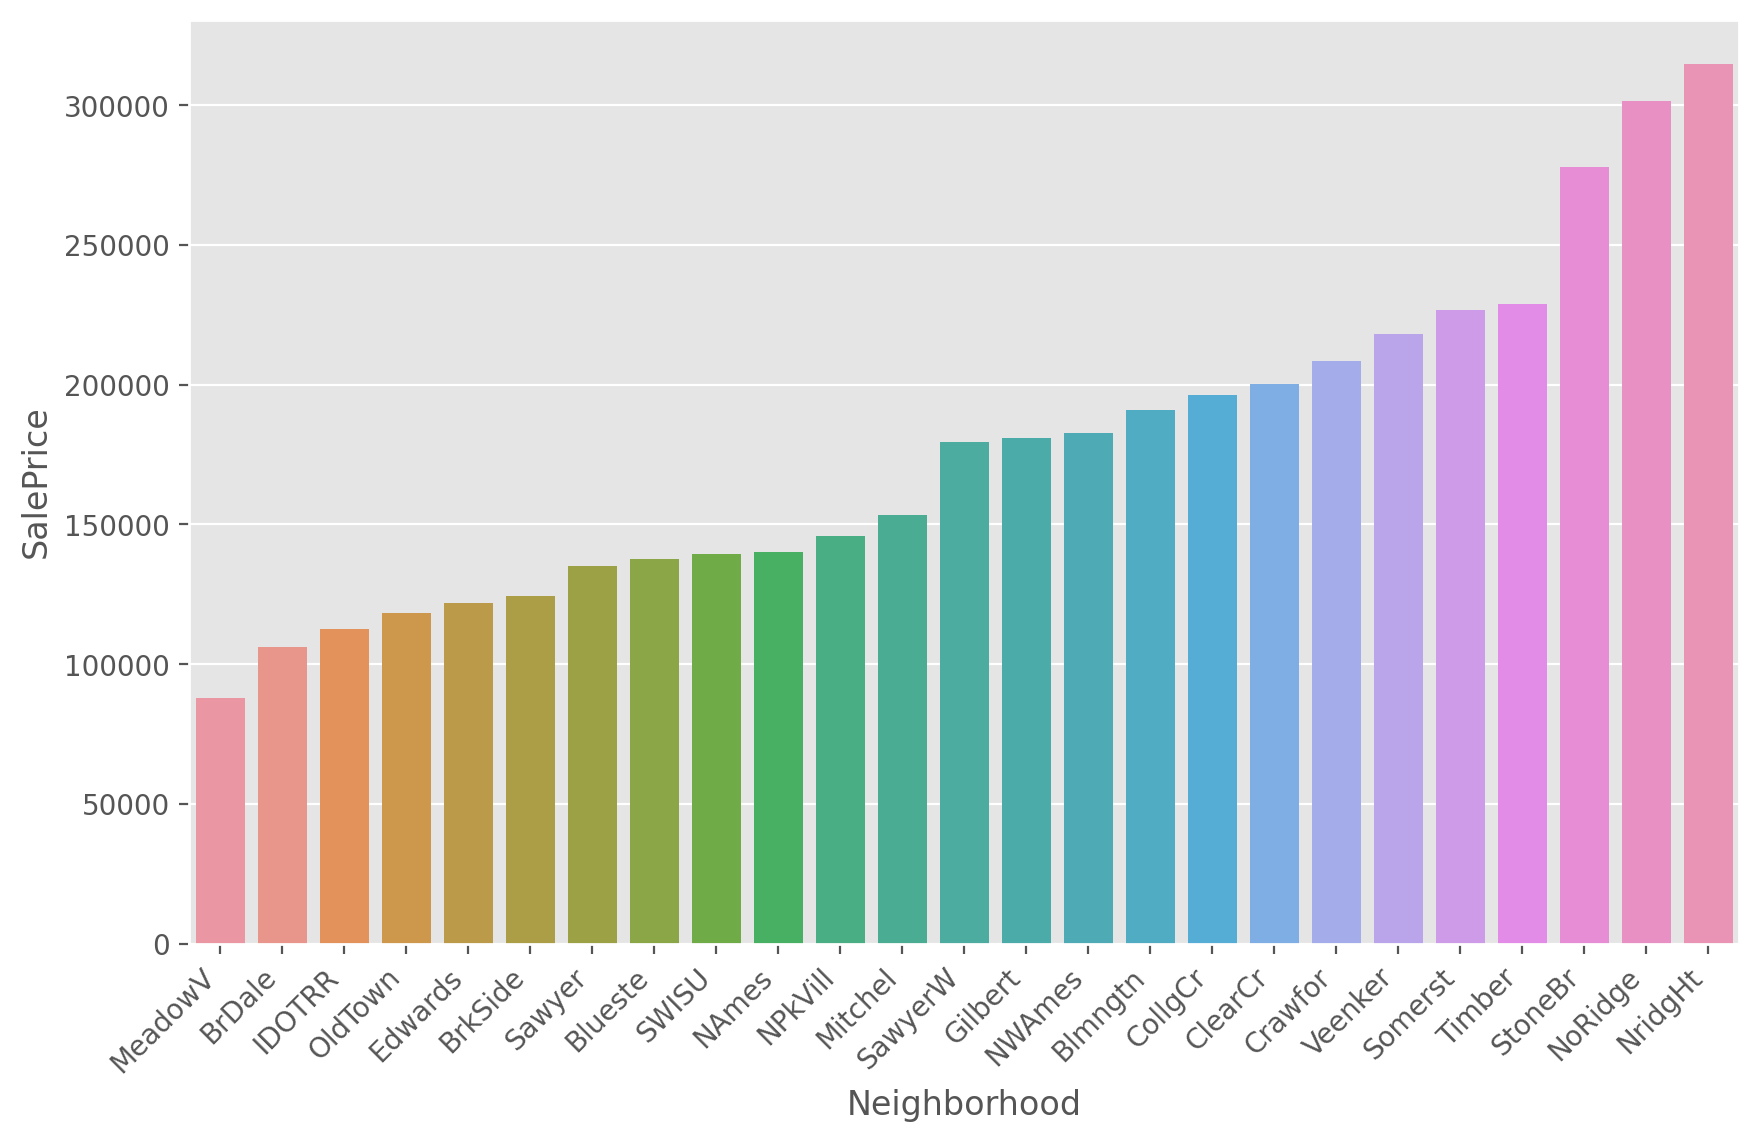

In [3025]:
# Look at the effect of the neigbourhood on sale price    
# find the median sale price for each neighborhood and sort 
med_hood = house_f.groupby('Neighborhood')['SalePrice'].median().sort_values()

# plot the median saleprice for each neighbourhood
fig, ax = plt.subplots(figsize = (10,6))
plt.xticks(rotation = 45, horizontalalignment='right')
sns.barplot(data = house_f, x = med_hood.index, y = med_hood)
plt.show()

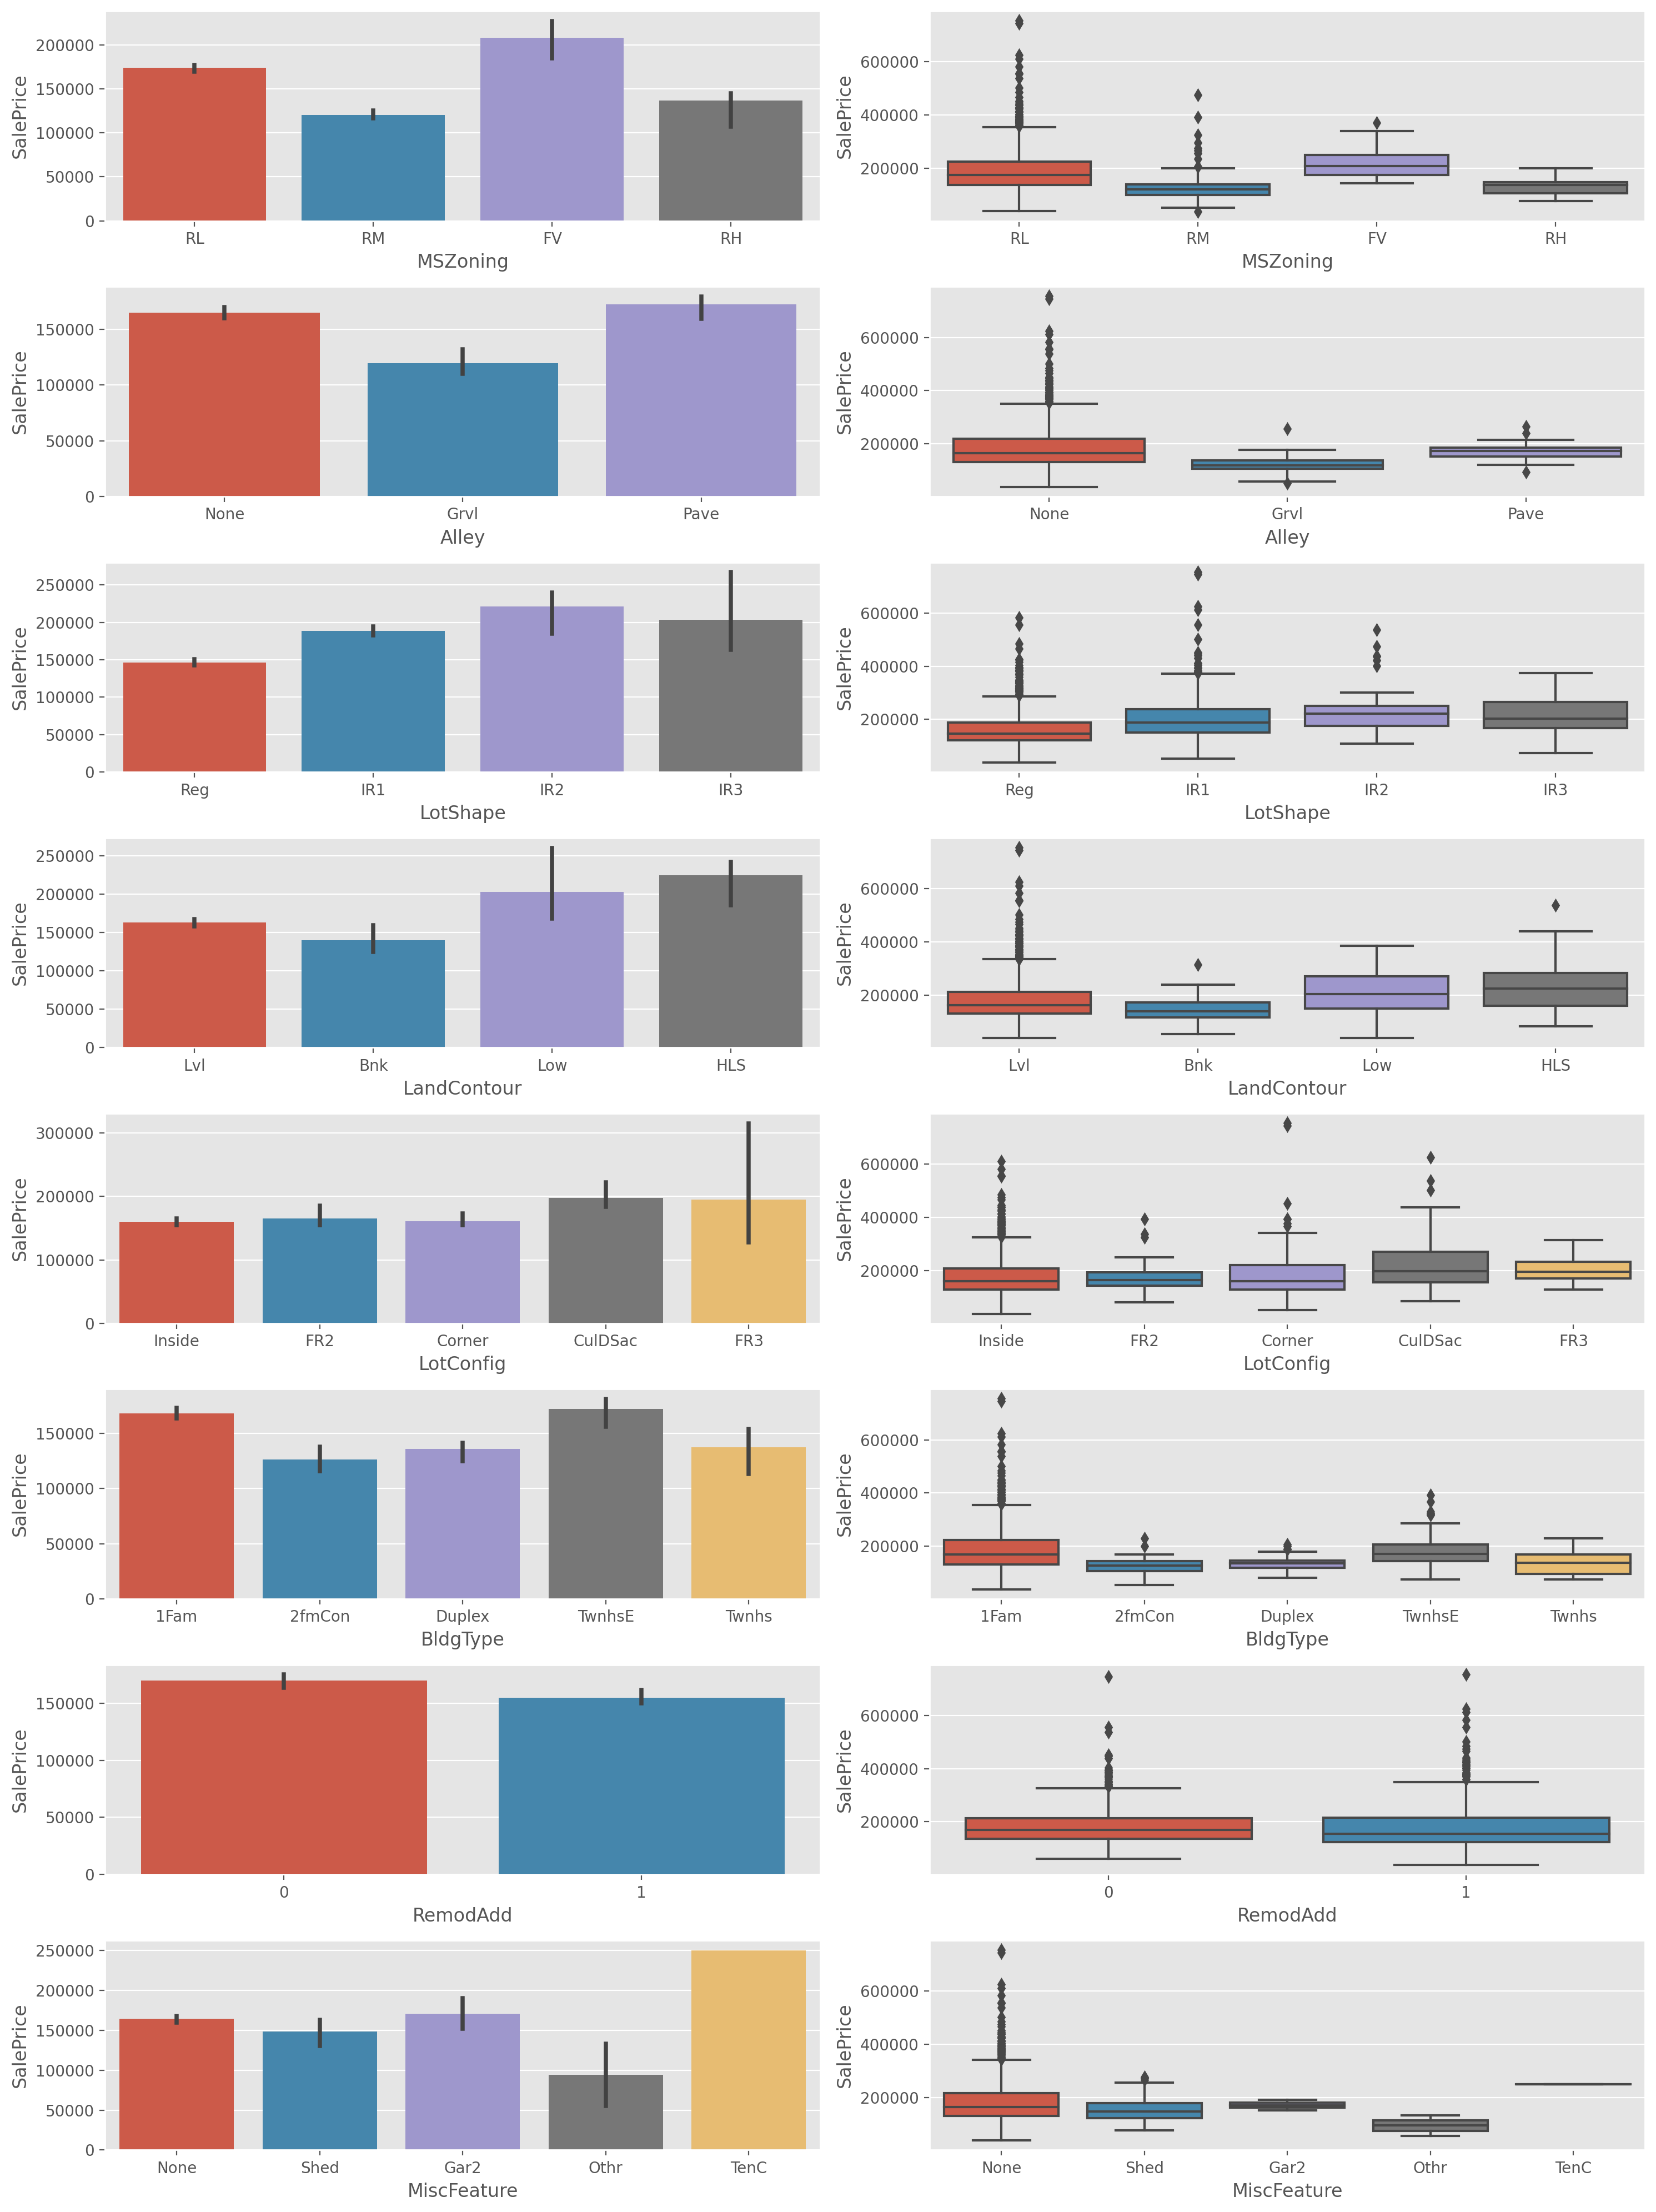

In [3026]:
# plot barplots for the nominal variables with 5 or less unique values
low_var_nom = [x for x in nominal if house_f[x].nunique() <= 5]

fig, ax = plt.subplots(ncols = 2, nrows= 8, figsize = (15,20))
for x in range(len(low_var_nom)):
    sns.barplot(data = house_f, x = low_var_nom[x], y = 'SalePrice', estimator = np.median, 
                ax = ax[x,0])
    sns.boxplot(data = house_f, x = low_var_nom[x], y = 'SalePrice', ax=ax[x,1])

plt.tight_layout()

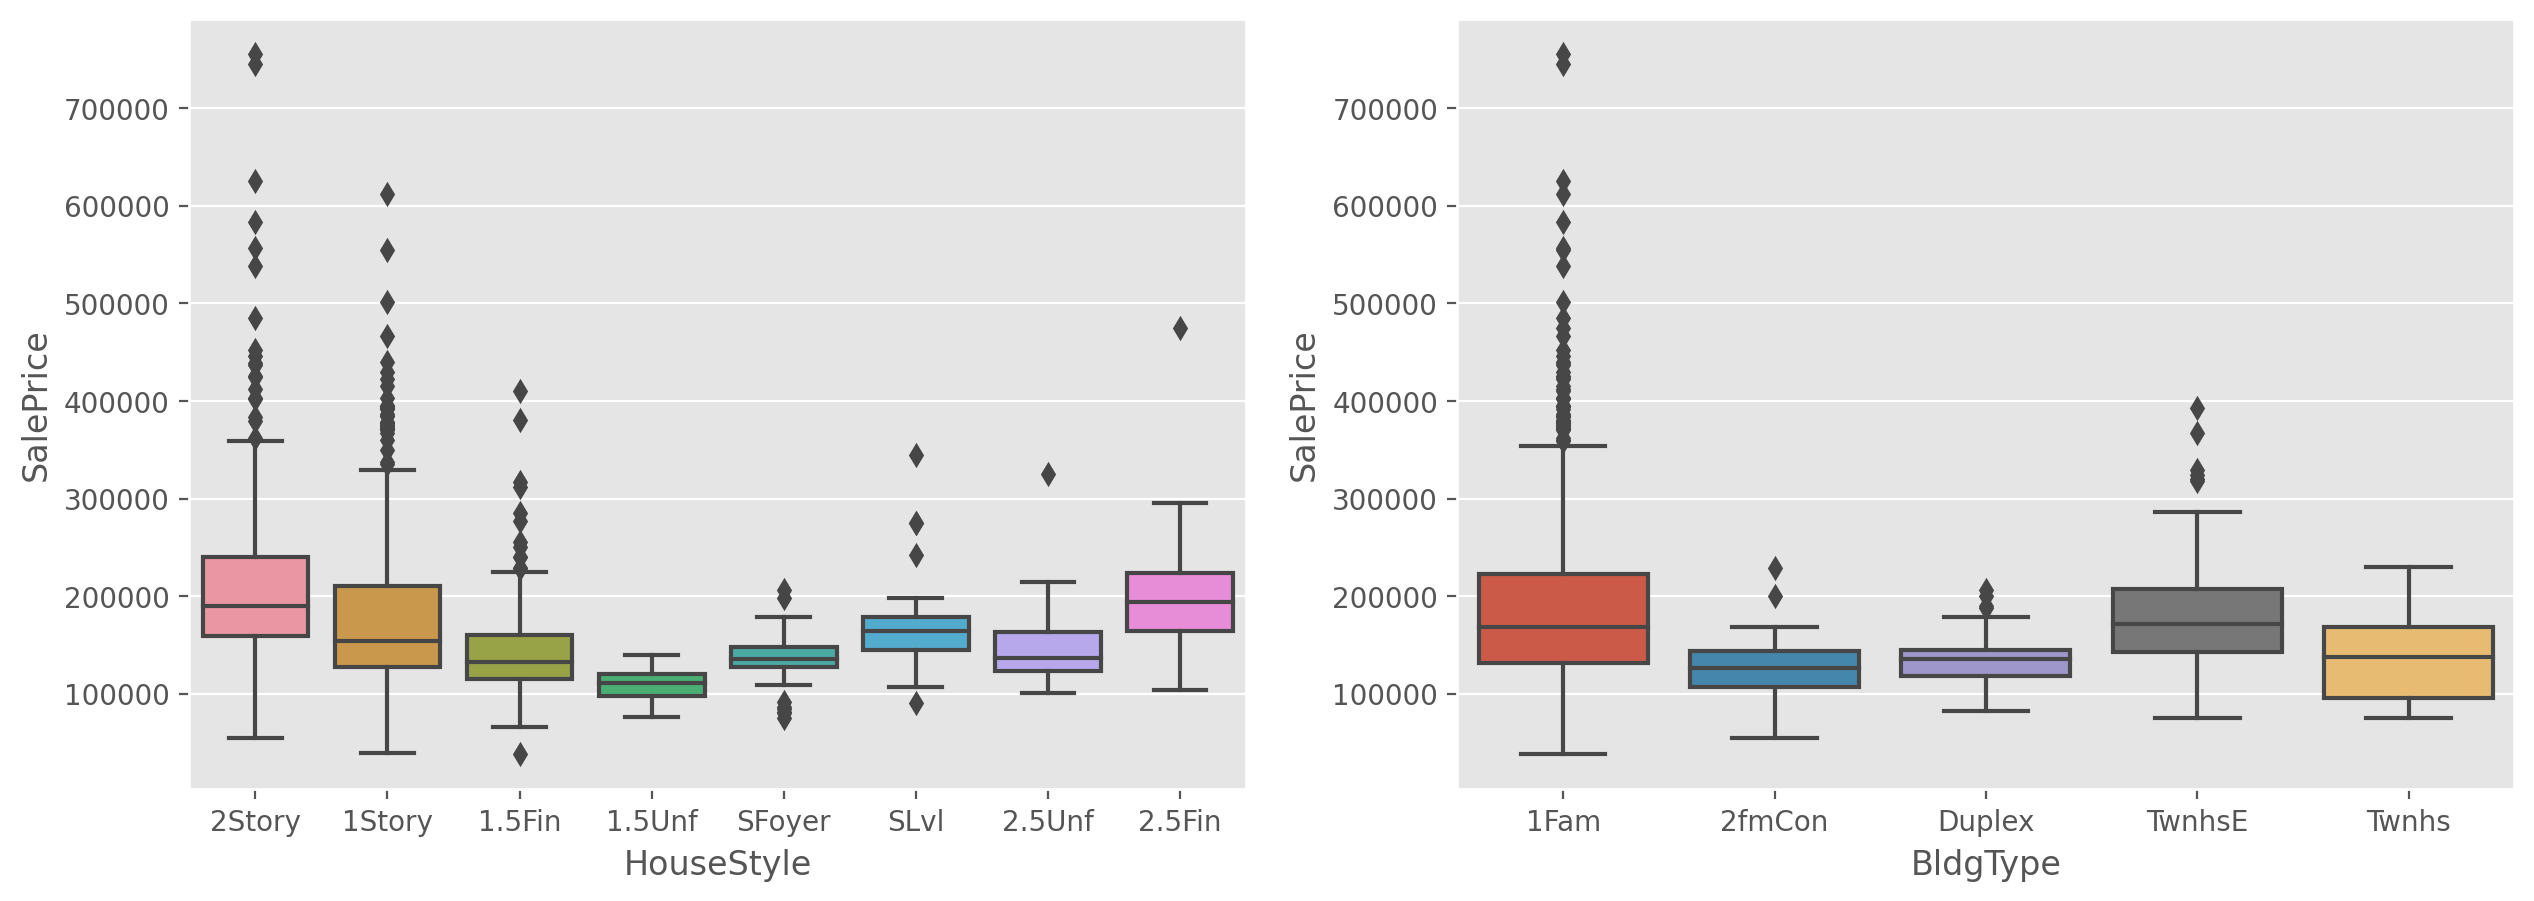

In [3027]:
# plot the sale price distribution of Housestyle and BldgType
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
sns.boxplot(data = house_f, x = 'HouseStyle', y = 'SalePrice', ax=ax[0])
sns.boxplot(data = house_f, x = 'BldgType', y = 'SalePrice', ax=ax[1])
plt.show()

## Conclusions from EDA

### Observations from correlation matrix
**Most highly correlated variables with Saleprice:**
- GrLivArea (above grade (ground) living area square feet) 
- GarageCars
- GarageArea
- TotalBsmtSF
- 1stFlrSF

Some variables show very low correlation with SalePrice. It may be worth removing some of these due to the high number of features we have

**Colinear variables**
- Age and YrBuilt (Drop YrBuilt as age is more precise considering YrSold varies)
- GarageCars and GarageArea (drop GarageCars - area is more precise)
- YearBuilt/Age and GarageYrBlt (drop GarageYrBlt - not all houses have a garage)
- GrLivArea and TotRmsAbvGrd (drop TotRmsAbvGrd - area is more precise)	
- TotalBsmtSF and 1stFlrSF (drop Total BsmtSF - all houses have 1stFlr but not all have Bsmt)
- Added variable TotalBath has higher correlation with sale price (therefore drop all other bath variables)
- GrLivArea and 2ndFlrSF (drop 2ndFlrSF


### Sale price distribution
The sale price distribution has right skewed distribution with a long tail. For the purpose of the exercise, we will keep these few high price houses in the model. However, it could be considered to remove them to create a more accurate model for 90% of the housing market. 

### Plotting
- Drop GarageType, there is an overlap between this variable and GarageArea (GarageType: none = GarageArea :0), however the same garage types show a wide distribution of sale prices. Seems to be more dependent on size
- Drop MiscFeature, there is an overlap between this variable and MiscVal (MiscFeature: none = MiscVal :0)

## Creating a model

### Linear Regression (without regularisation)

In [3028]:
# Drop colinear columns
colinear = ['YearBuilt','GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd', 'TotalBsmtSF', 'MiscFeature', 'BsmtFullBath', 
                'BsmtHalfBath', 'FullBath', 'HalfBath', '2ndFlrSF', 'GarageType']

house_f.drop(colinear, axis = 1, inplace = True)

In [3029]:
# drop variables with very low correlation as we have such a high number of variables
low_corr = []            
for a,b in house_f.corr().items():
    for x,y in b.items():
        if a == 'SalePrice':
            if abs(y) < 0.1:
                low_corr.append(x)

low_corr            

['LandSlope', 'RemodAdd', '3SsnPorch', 'MiscVal', 'MoSold', 'YrSold']

In [3030]:
# remove YrSold from low correlation list to drop as we need this later
low_corr.remove('YrSold')

In [3031]:
# drop the low correlated values
house_f.drop(columns = low_corr, inplace = True)

In [3032]:
# dummify categorical variables
house_fdum = pd.get_dummies(house_f, columns = [x for x in house_f.columns if x in nominal], drop_first = True)

In [3033]:
# look at the proportion of houses per year sold (as we will split train and test by this metric)
house['YrSold'].value_counts(normalize = True)

2009    0.232477
2007    0.226232
2006    0.215822
2008    0.206801
2010    0.118668
Name: YrSold, dtype: float64

In [3034]:
# create test train split - this should be done by year (pre 2010 = train, 2010 is test)
X_train = house_fdum[house_fdum['YrSold'] < 2010].copy()
y_train = X_train.pop('SalePrice')

X_test = house_fdum[house_fdum['YrSold'] == 2010].copy()
y_test = X_test.pop('SalePrice')

# drop year sold due to low correlation
X_train.drop(columns = 'YrSold', inplace = True)
X_test.drop(columns = 'YrSold', inplace = True)

In [3035]:
# Check dimensions of the train and test sets
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1270, 97) (1270,)
(171, 97) (171,)


In [3036]:
# select numerical columns which we still have in our dataframe
cols = [x for x in X_train.columns if x in numerical]

# scale the numerical values in our train and test sets using standard scaler
scaler = StandardScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

In [3037]:
# Define a function for linear regression 
def linear_regression(model, X_train, y_train, X_test, y_test):
    cvs = cross_val_score(model, X_train, y_train, cv=5)
    cvs_mean = np.mean(cvs)
    model.fit(X_train,y_train)
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    results = pd.Series([cvs_mean, train_score, test_score], index = ['cross validation mean', 'training score', 'test_score'])
    return pd.DataFrame({'LR results' : results})

In [3038]:
# Instatiate the model
lr = LinearRegression()
# Input defined X_train, y_train, X_test, y_test to function
linear_regression(lr, X_train, y_train, X_test, y_test)

LR results
cross validation mean    0.782027
training score           0.845420
test_score               0.837679

In [3039]:
# Look a the magnitude of the coefficients from linear regression
lr_coef = pd.DataFrame(list(zip(X_train.columns,lr.coef_)), columns = ['variable','coefficient'])
lr_coef['abs'] = abs(lr_coef['coefficient'])
lr_coef.sort_values(by = 'abs', ascending = False)[:20]

variable   coefficient           abs
64        Condition2_PosA  85385.240588  85385.240588
55        Condition1_Norm  75825.676550  75825.676550
85           SaleType_Con  69647.798578  69647.798578
62        Condition2_None -67033.943961  67033.943961
51   Neighborhood_StoneBr  59276.831034  59276.831034
45   Neighborhood_NridgHt  56095.127890  56095.127890
44   Neighborhood_NoRidge  49775.782197  49775.782197
6               GrLivArea  44345.701971  44345.701971
70         BldgType_Twnhs -44302.133286  44302.133286
71        BldgType_TwnhsE -37349.208902  37349.208902
58        Condition1_RRAe -34807.188789  34807.188789
87         SaleType_ConLI  34076.495800  34076.495800
89           SaleType_New  32126.822633  32126.822633
72      HouseStyle_1.5Unf  30537.982184  30537.982184
21           LotShape_IR3 -30351.854667  30351.854667
92  SaleCondition_AdjLand  29157.755435  29157.755435
36   Neighborhood_Edwards -28036.123538  28036.123538
73      HouseStyle_1Story  24345.330190  24345.330190
84           SaleType_CWD  22956.172168  22956.172168
40   Neighborhood_Mitchel -22185.724946  22185.724946

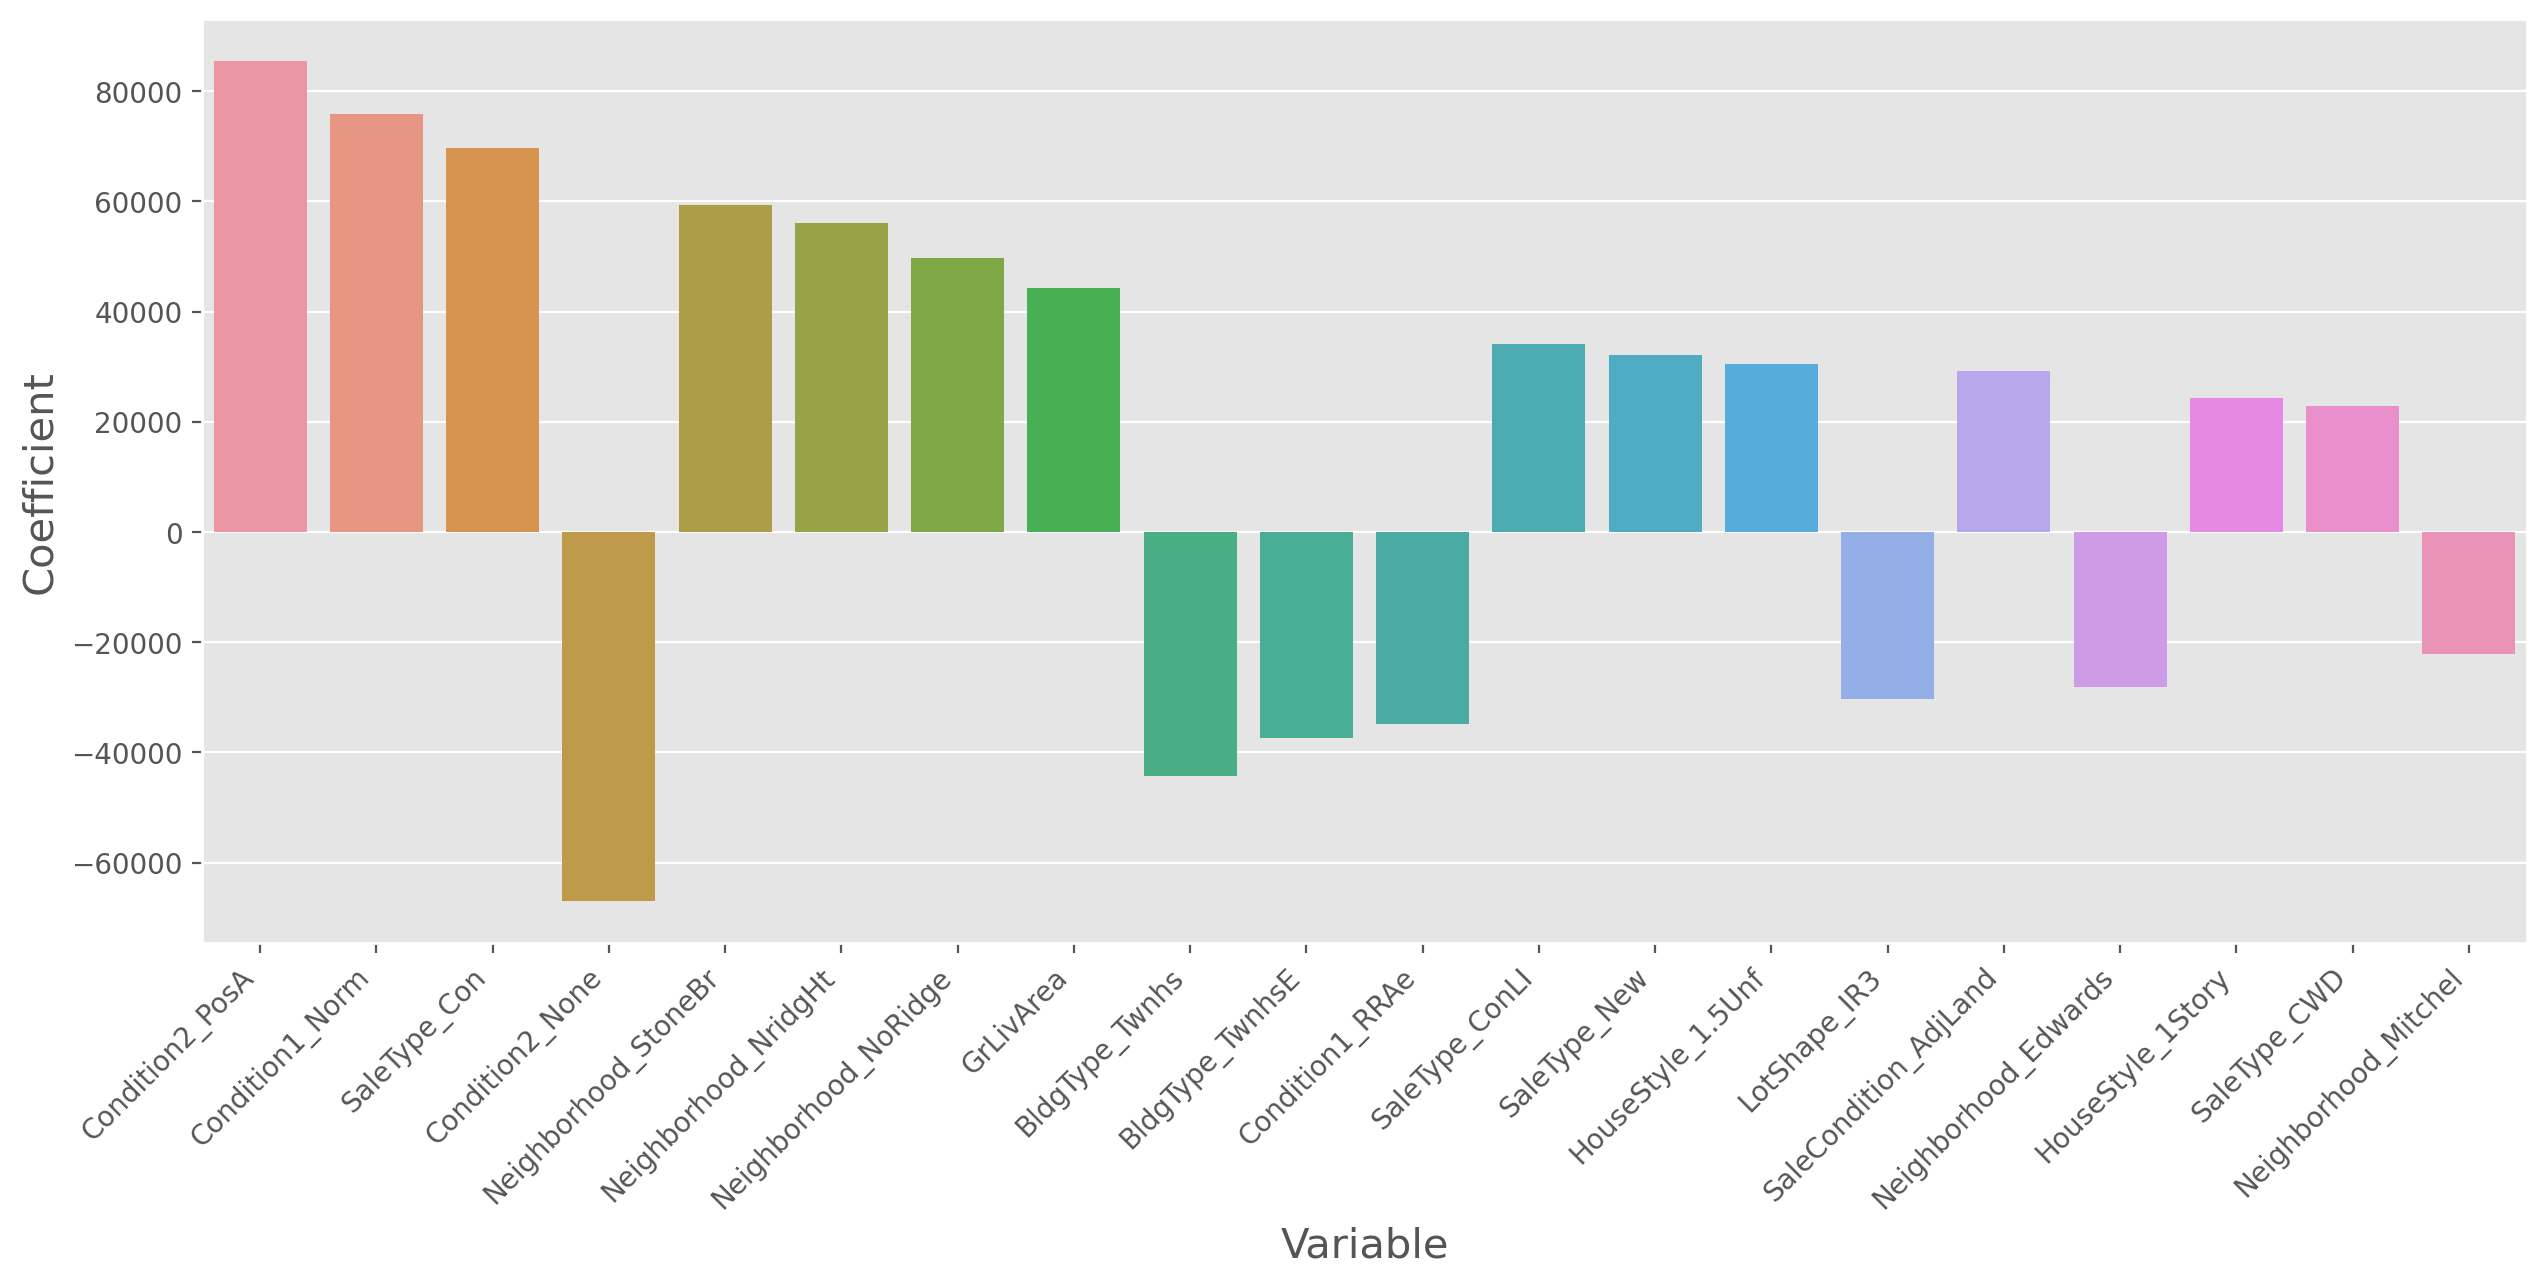

In [3040]:
# Plot the coefficents from linear regression
fig, ax = plt.subplots(figsize = (15,6))
sns.barplot(data= lr_coef.sort_values(by = 'abs', ascending = False)[:20], 
            x = 'variable', y = 'coefficient', ax=ax)
ax.set_xlabel("Variable", fontsize = 15)
ax.set_ylabel("Coefficient", fontsize = 15)
plt.xticks(rotation = 45, horizontalalignment='right')
plt.show()

### Linear Regression with regularization

In [3041]:
# To account for the high number of variables, try putting all variables into a linear regression with regularization

In [3042]:
# Ridge regression
#   create a RidgeCV model instance 
optimal_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)
    
# fit the model
optimal_ridge.fit(X_train,y_train)
    
# find the optimal alpha
optimal_ridge_alpha = optimal_ridge.alpha_
    
#   evaluate the model on the training set
ridge_train = optimal_ridge.score(X_train, y_train)
    
#   evaluate on the test set
ridge_test = optimal_ridge.score(X_test, y_test)

# Display results
print('Optimal alpha:', optimal_ridge_alpha, '\nRidge train score:', ridge_train, '\nRidge test score:', ridge_test) 

Optimal alpha: 6.747544053110695 
Ridge train score: 0.8380659385799044 
Ridge test score: 0.8492847222882148


In [3043]:
# cross validate the results from the optimal alpha
ridge = Ridge(alpha=optimal_ridge_alpha)
r_cvs = cross_val_score(ridge, X_train, y_train, cv=5)
print('Cross validation scores:', r_cvs, '\nMean cross validation score:', r_cvs.mean())

Cross validation scores: [0.87371633 0.80341523 0.82637323 0.81811059 0.67628948] 
Mean cross validation score: 0.7995809718112332


In [3044]:
# look at the magnitude of the coefficients from ridge regression
coef_ridge = pd.DataFrame(list(zip(X_train.columns, optimal_ridge.coef_)), columns = ['variable','coefficient'])
coef_ridge['abs'] = abs(coef_ridge['coefficient'])
coef_ridge.sort_values(by = 'abs', ascending = False)[:10]

variable   coefficient           abs
45  Neighborhood_NridgHt  46098.520676  46098.520676
44  Neighborhood_NoRidge  41284.317246  41284.317246
51  Neighborhood_StoneBr  40957.433378  40957.433378
6              GrLivArea  40041.057300  40041.057300
70        BldgType_Twnhs -27906.108954  27906.108954
71       BldgType_TwnhsE -26455.355561  26455.355561
36  Neighborhood_Edwards -22902.707216  22902.707216
35  Neighborhood_Crawfor  19464.315010  19464.315010
55       Condition1_Norm  19269.531897  19269.531897
21          LotShape_IR3 -18354.908227  18354.908227

In [3045]:
# Lasso regression
# Create a LassoCV model instance 
optimal_lasso = LassoCV(n_alphas=500, cv=10)
                        
# fit the model
optimal_lasso.fit(X_train, y_train)

# get the best alpha
optimal_lasso_alpha = optimal_lasso.alpha_

#   evaluate the model on the training set
lasso_train = optimal_lasso.score(X_train, y_train)
    
#   evaluate on the test set
lasso_test = optimal_lasso.score(X_test, y_test)

# Display results
print('Optimal alpha:', optimal_lasso_alpha, '\nLasso train score:', lasso_train, '\nLasso test score:', lasso_test) 

Optimal alpha: 121.59843623324029 
Lasso train score: 0.8334578355893895 
Lasso test score: 0.8496551802639944


In [3046]:
# cross validate the results from the optimal alpha
lasso = Lasso(alpha=optimal_lasso_alpha)
l_cvs = cross_val_score(lasso, X_train, y_train, cv=5)
print('Cross validation scores:', l_cvs, '\nMean cross validation score:', l_cvs.mean())

Cross validation scores: [0.87329609 0.80135418 0.82804124 0.81946609 0.68213474] 
Mean cross validation score: 0.8008584679593124


In [3047]:
# look at the magnitude of the coefficients from lasso regression
coef_lasso = pd.DataFrame(list(zip(X_train.columns, optimal_lasso.coef_)), columns = ['variable','coefficient'])
coef_lasso['abs'] = abs(coef_lasso['coefficient'])
coef_lasso.sort_values(by = 'abs', ascending = False)[:10]

variable   coefficient           abs
45  Neighborhood_NridgHt  60618.360167  60618.360167
51  Neighborhood_StoneBr  59186.576883  59186.576883
44  Neighborhood_NoRidge  57578.260176  57578.260176
6              GrLivArea  39252.065677  39252.065677
70        BldgType_Twnhs -28912.207383  28912.207383
35  Neighborhood_Crawfor  27810.194505  27810.194505
71       BldgType_TwnhsE -25823.411671  25823.411671
50  Neighborhood_Somerst  21259.727253  21259.727253
89          SaleType_New  19992.520529  19992.520529
73     HouseStyle_1Story  15500.223053  15500.223053

In [3048]:
# Find the coefficients which lasso has reduced to 0
print(coef_lasso[coef_lasso['coefficient'] == 0].shape[0])
coef_lasso['variable'][coef_lasso['coefficient'] == 0].values

47


array(['OpenPorchSF', 'MSZoning_RH', 'Alley_Pave', 'LotShape_Reg',
       'LandContour_Low', 'LotConfig_FR3', 'LotConfig_Inside',
       'Neighborhood_Blueste', 'Neighborhood_ClearCr',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_OldTown', 'Neighborhood_SawyerW',
       'Neighborhood_Timber', 'Condition1_PosA', 'Condition1_PosN',
       'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe',
       'Condition1_RRNn', 'Condition2_None', 'Condition2_Norm',
       'Condition2_PosA', 'Condition2_RRAe', 'Condition2_RRAn',
       'Condition2_RRNn', 'BldgType_2fmCon', 'HouseStyle_2.5Fin',
       'HouseStyle_2.5Unf', 'HouseStyle_SFoyer', 'HouseStyle_SLvl',
       'Foundation_CBlock', 'Foundation_Stone', 'Foundation_Wood',
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca',
     

In [3049]:
# Elasticnet regression
# Create an ElasticnetCV model instance 
optimal_enet = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 25), n_alphas=100, cv=10)
                        
# fit the model
optimal_enet.fit(X_train, y_train)

# get the best alpha and l1 ration
optimal_enet_alpha = optimal_enet.alpha_
optimal_l1_ratio = optimal_enet.l1_ratio_

#   evaluate the model on the training set
enet_train = optimal_enet.score(X_train, y_train)
    
#   evaluate on the test set
enet_test = optimal_enet.score(X_test, y_test)

# Display results
print('Optimal alpha:', optimal_enet_alpha, '\nOptimal l1 ratio:', optimal_l1_ratio)
print('Elastic net train score:', enet_train, 'Elastic net test score:', enet_test) 

Optimal alpha: 120.66685024840262 
Optimal l1 ratio: 1.0
Elastic net train score: 0.8335135958208573 Elastic net test score: 0.8496686803567453


In [3050]:
# cross validate the results from the optimal alpha
enet = ElasticNet(alpha=optimal_enet_alpha, l1_ratio=optimal_l1_ratio)
e_cvs = cross_val_score(lasso, X_train, y_train, cv=5)
print('Cross validation scores:', e_cvs, '\nMean cross validation score:', e_cvs.mean())

Cross validation scores: [0.87329609 0.80135418 0.82804124 0.81946609 0.68213474] 
Mean cross validation score: 0.8008584679593124


In [3051]:
# look at the magnitude of the coefficients from elastic net regression
coef_enet = pd.DataFrame(list(zip(X_train.columns, optimal_enet.coef_)), columns = ['variable','coefficient'])
coef_enet['abs'] = abs(coef_enet['coefficient'])
coef_enet.sort_values(by = 'abs', ascending = False)[:10]

variable   coefficient           abs
45  Neighborhood_NridgHt  60645.581881  60645.581881
51  Neighborhood_StoneBr  59250.873561  59250.873561
44  Neighborhood_NoRidge  57610.746306  57610.746306
6              GrLivArea  39266.436318  39266.436318
70        BldgType_Twnhs -29001.981681  29001.981681
35  Neighborhood_Crawfor  27838.597026  27838.597026
71       BldgType_TwnhsE -25871.824959  25871.824959
50  Neighborhood_Somerst  21294.780654  21294.780654
89          SaleType_New  20002.523776  20002.523776
73     HouseStyle_1Story  15518.380475  15518.380475

In [3052]:
# Compare the Rsquared scores for each regression model
regression = pd.Series([ridge_test, lasso_test, enet_test], index = ['ridge', 'lasso', 'enet'])
pd.DataFrame({'Regression test scores' : regression})

Regression test scores
ridge                0.849285
lasso                0.849655
enet                 0.849669

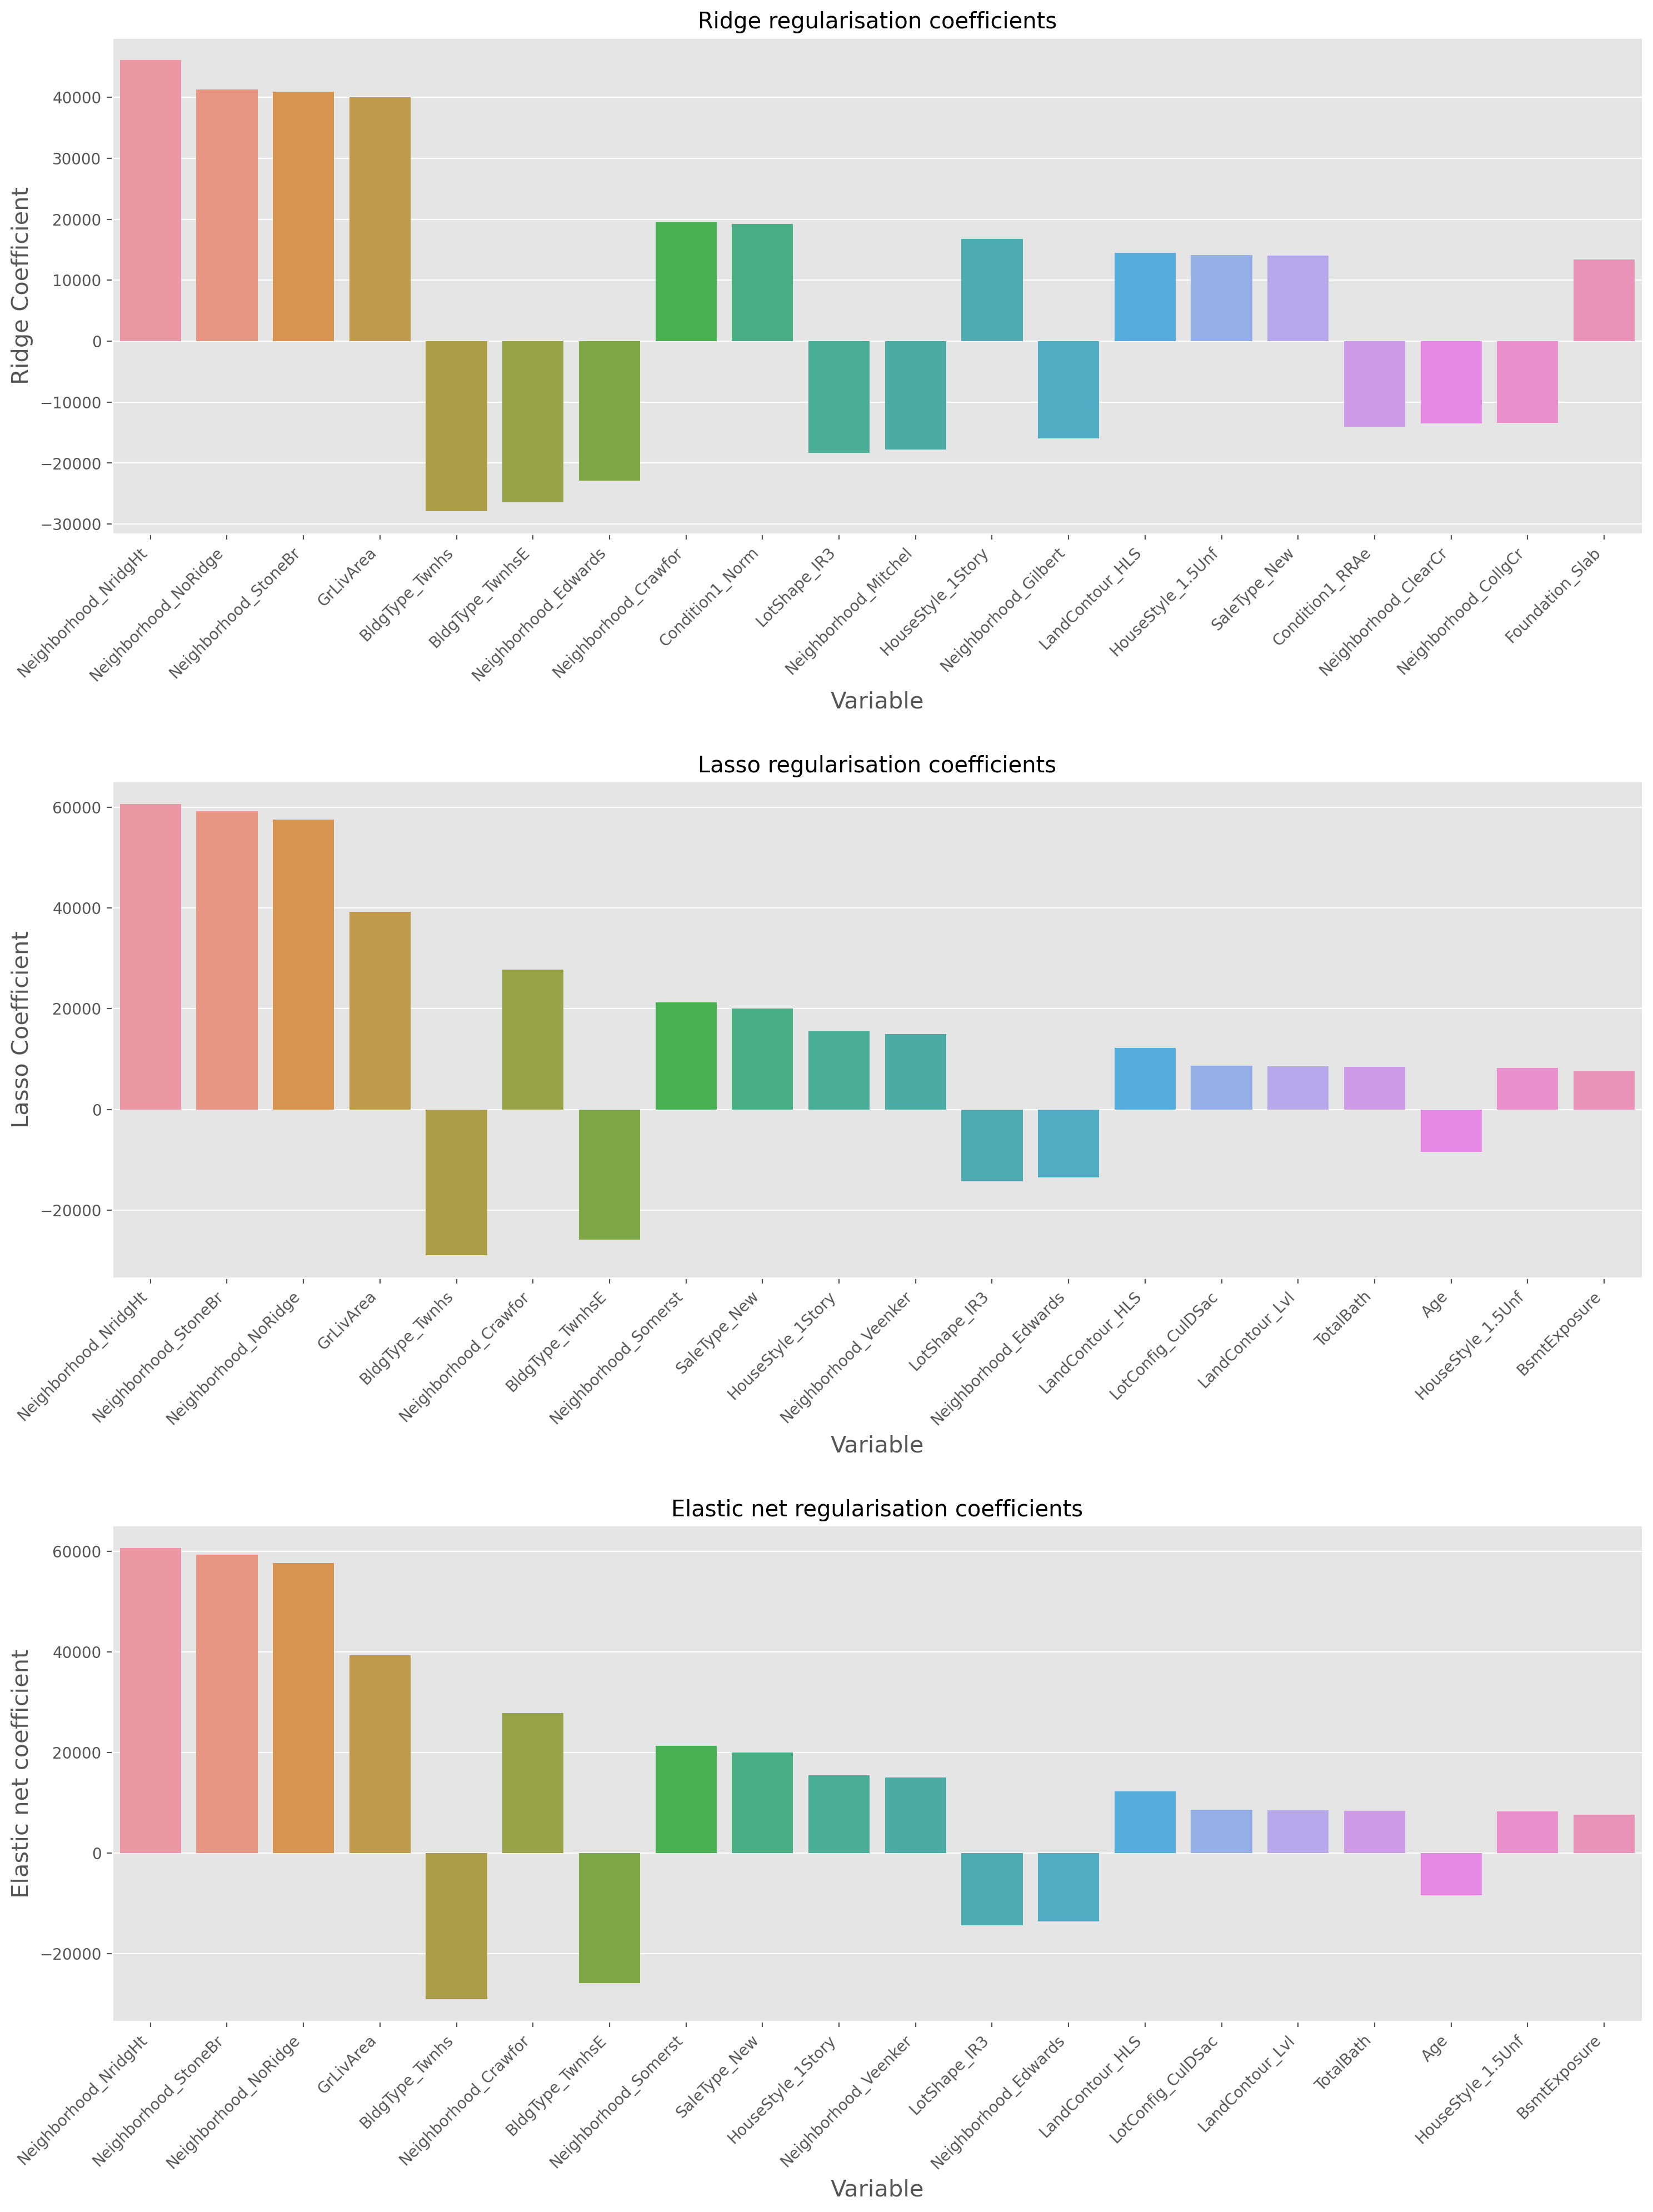

In [3053]:
# plot the 20 coefficents with the greatest magnitude from each method of regularization
fig, ax = plt.subplots(nrows = 3, figsize = (15,20))

ridge_largest = coef_ridge.sort_values(by = 'abs', ascending = False)[:20]
sns.barplot(data = ridge_largest, x = 'variable', y = 'coefficient', ax = ax[0])
ax[0].set_xlabel("Variable\n", fontsize = 15)
ax[0].set_ylabel("Ridge Coefficient", fontsize = 15)
ax[0].set_xticklabels(labels = ridge_largest['variable'], rotation = 45, horizontalalignment='right')
ax[0].set_title('Ridge regularisation coefficients')

lasso_largest = coef_lasso.sort_values(by = 'abs', ascending = False)[:20]
sns.barplot(data = lasso_largest, x = 'variable', y = 'coefficient', ax=ax[1])
ax[1].set_xlabel("Variable", fontsize = 15)
ax[1].set_ylabel("Lasso Coefficient", fontsize = 15)
ax[1].set_xticklabels(labels = lasso_largest['variable'], rotation = 45, horizontalalignment='right')
ax[1].set_title('Lasso regularisation coefficients')

enet_largest = coef_enet.sort_values(by = 'abs', ascending = False)[:20]
sns.barplot(data = enet_largest, x = 'variable', y = 'coefficient', ax=ax[2])
ax[2].set_xlabel("Variable", fontsize = 15)
ax[2].set_ylabel("Elastic net coefficient", fontsize = 15)
ax[2].set_xticklabels(labels = enet_largest['variable'], rotation = 45, horizontalalignment='right')
ax[2].set_title('Elastic net regularisation coefficients')

plt.tight_layout()
plt.show()

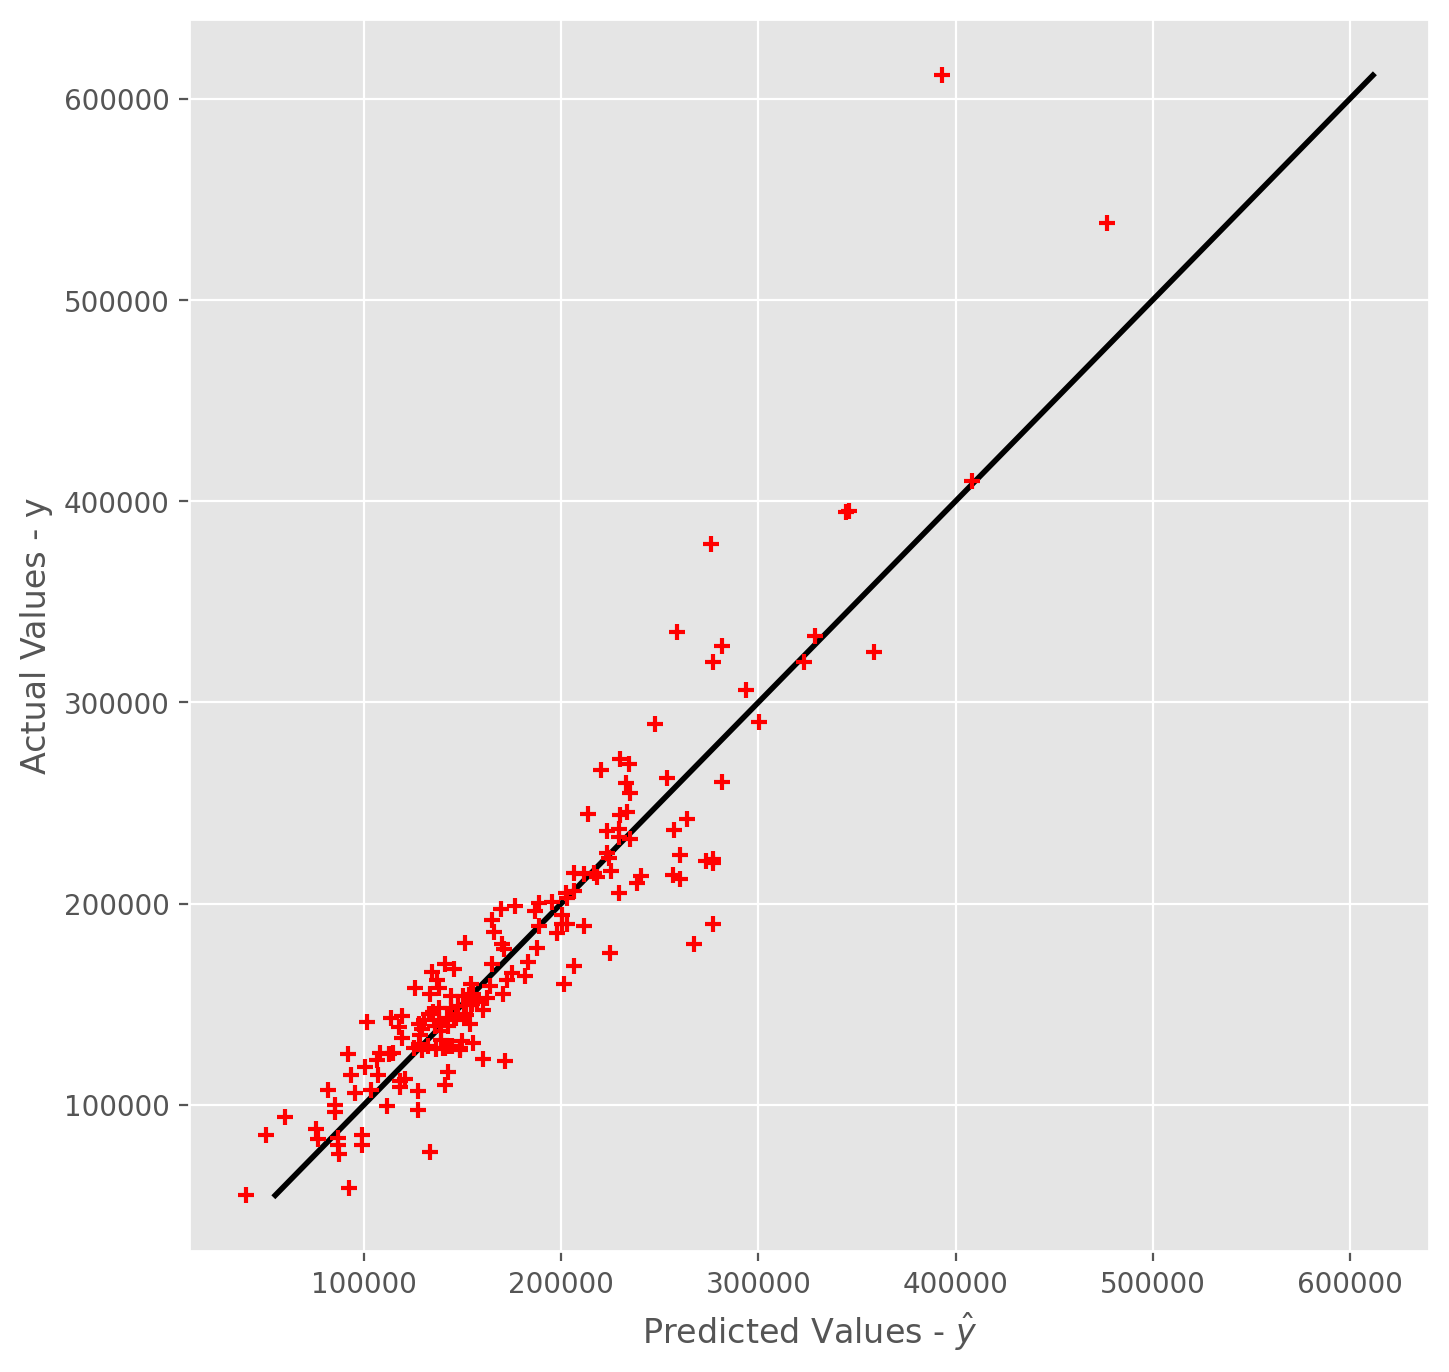

In [3054]:
# plot the values of y predicted by the lasso method (best predictions) against the true values of y
predictions_train = optimal_lasso.predict(X_train)
predictions = optimal_lasso.predict(X_test)

plt.figure(figsize=(8, 8))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='k', lw=2)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - y")
plt.show()

In [3077]:
# calculate the residuals for the lasso method for the training dataset
df_train = pd.DataFrame({'y_train': y_train, 'y_hat' : predictions_train})
df_train['residuals'] = df_train['y_train'] - df_train['y_hat']

# calculate the residuals for the lasso method for the test dataset
df_test = pd.DataFrame({'y_test': y_test, 'y_hat' : predictions})
df_test['residuals'] = df_test['y_test'] - df_test['y_hat']
df_test

y_test          y_hat     residuals
16    149000  147866.262036   1133.737964
24    154000  144187.224540   9812.775460
26    134800  128322.223171   6477.776829
27    306000  293693.832378  12306.167622
33    165500  174879.074830  -9379.074830
...      ...            ...           ...
1438  149700  154060.008171  -4360.008171
1446  157900  138220.523819  19679.476181
1456  210000  238517.003811 -28517.003811
1457  266500  220166.588587  46333.411413
1458  142125  145478.976932  -3353.976932

[171 rows x 3 columns]

### CONCLUSIONS
With each of the models we are getting quite a high Rsquared score for the test sets. The highest Rsquared is from the lasso method (worth noting that elastic net is using l1 ratio =1 aka completely lasso). However, there is not a significant difference between the models. 

Across the models we see some consistency in the variables with the largest coefficients, which therefore have the biggest impact on house prices. Larger GrLivArea and specific neighborhoods e.g. NridgeHt, StoneBr and NoRidge are contributing most strongly to increased house prices. 

The linear regression model without regularisation does not seem particularly trustworthy as the largest coefficient is for Condition1/2 and sale type, while lasso is eliminating these coefficients completely. With more time it would be worth investigating the relationships between these variables further and limiting which ones are included in the model.

From the graph of y against predicted y, it is worth noting that at higher sale prices, the residuals are getting larger, and the model is not performing so well

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

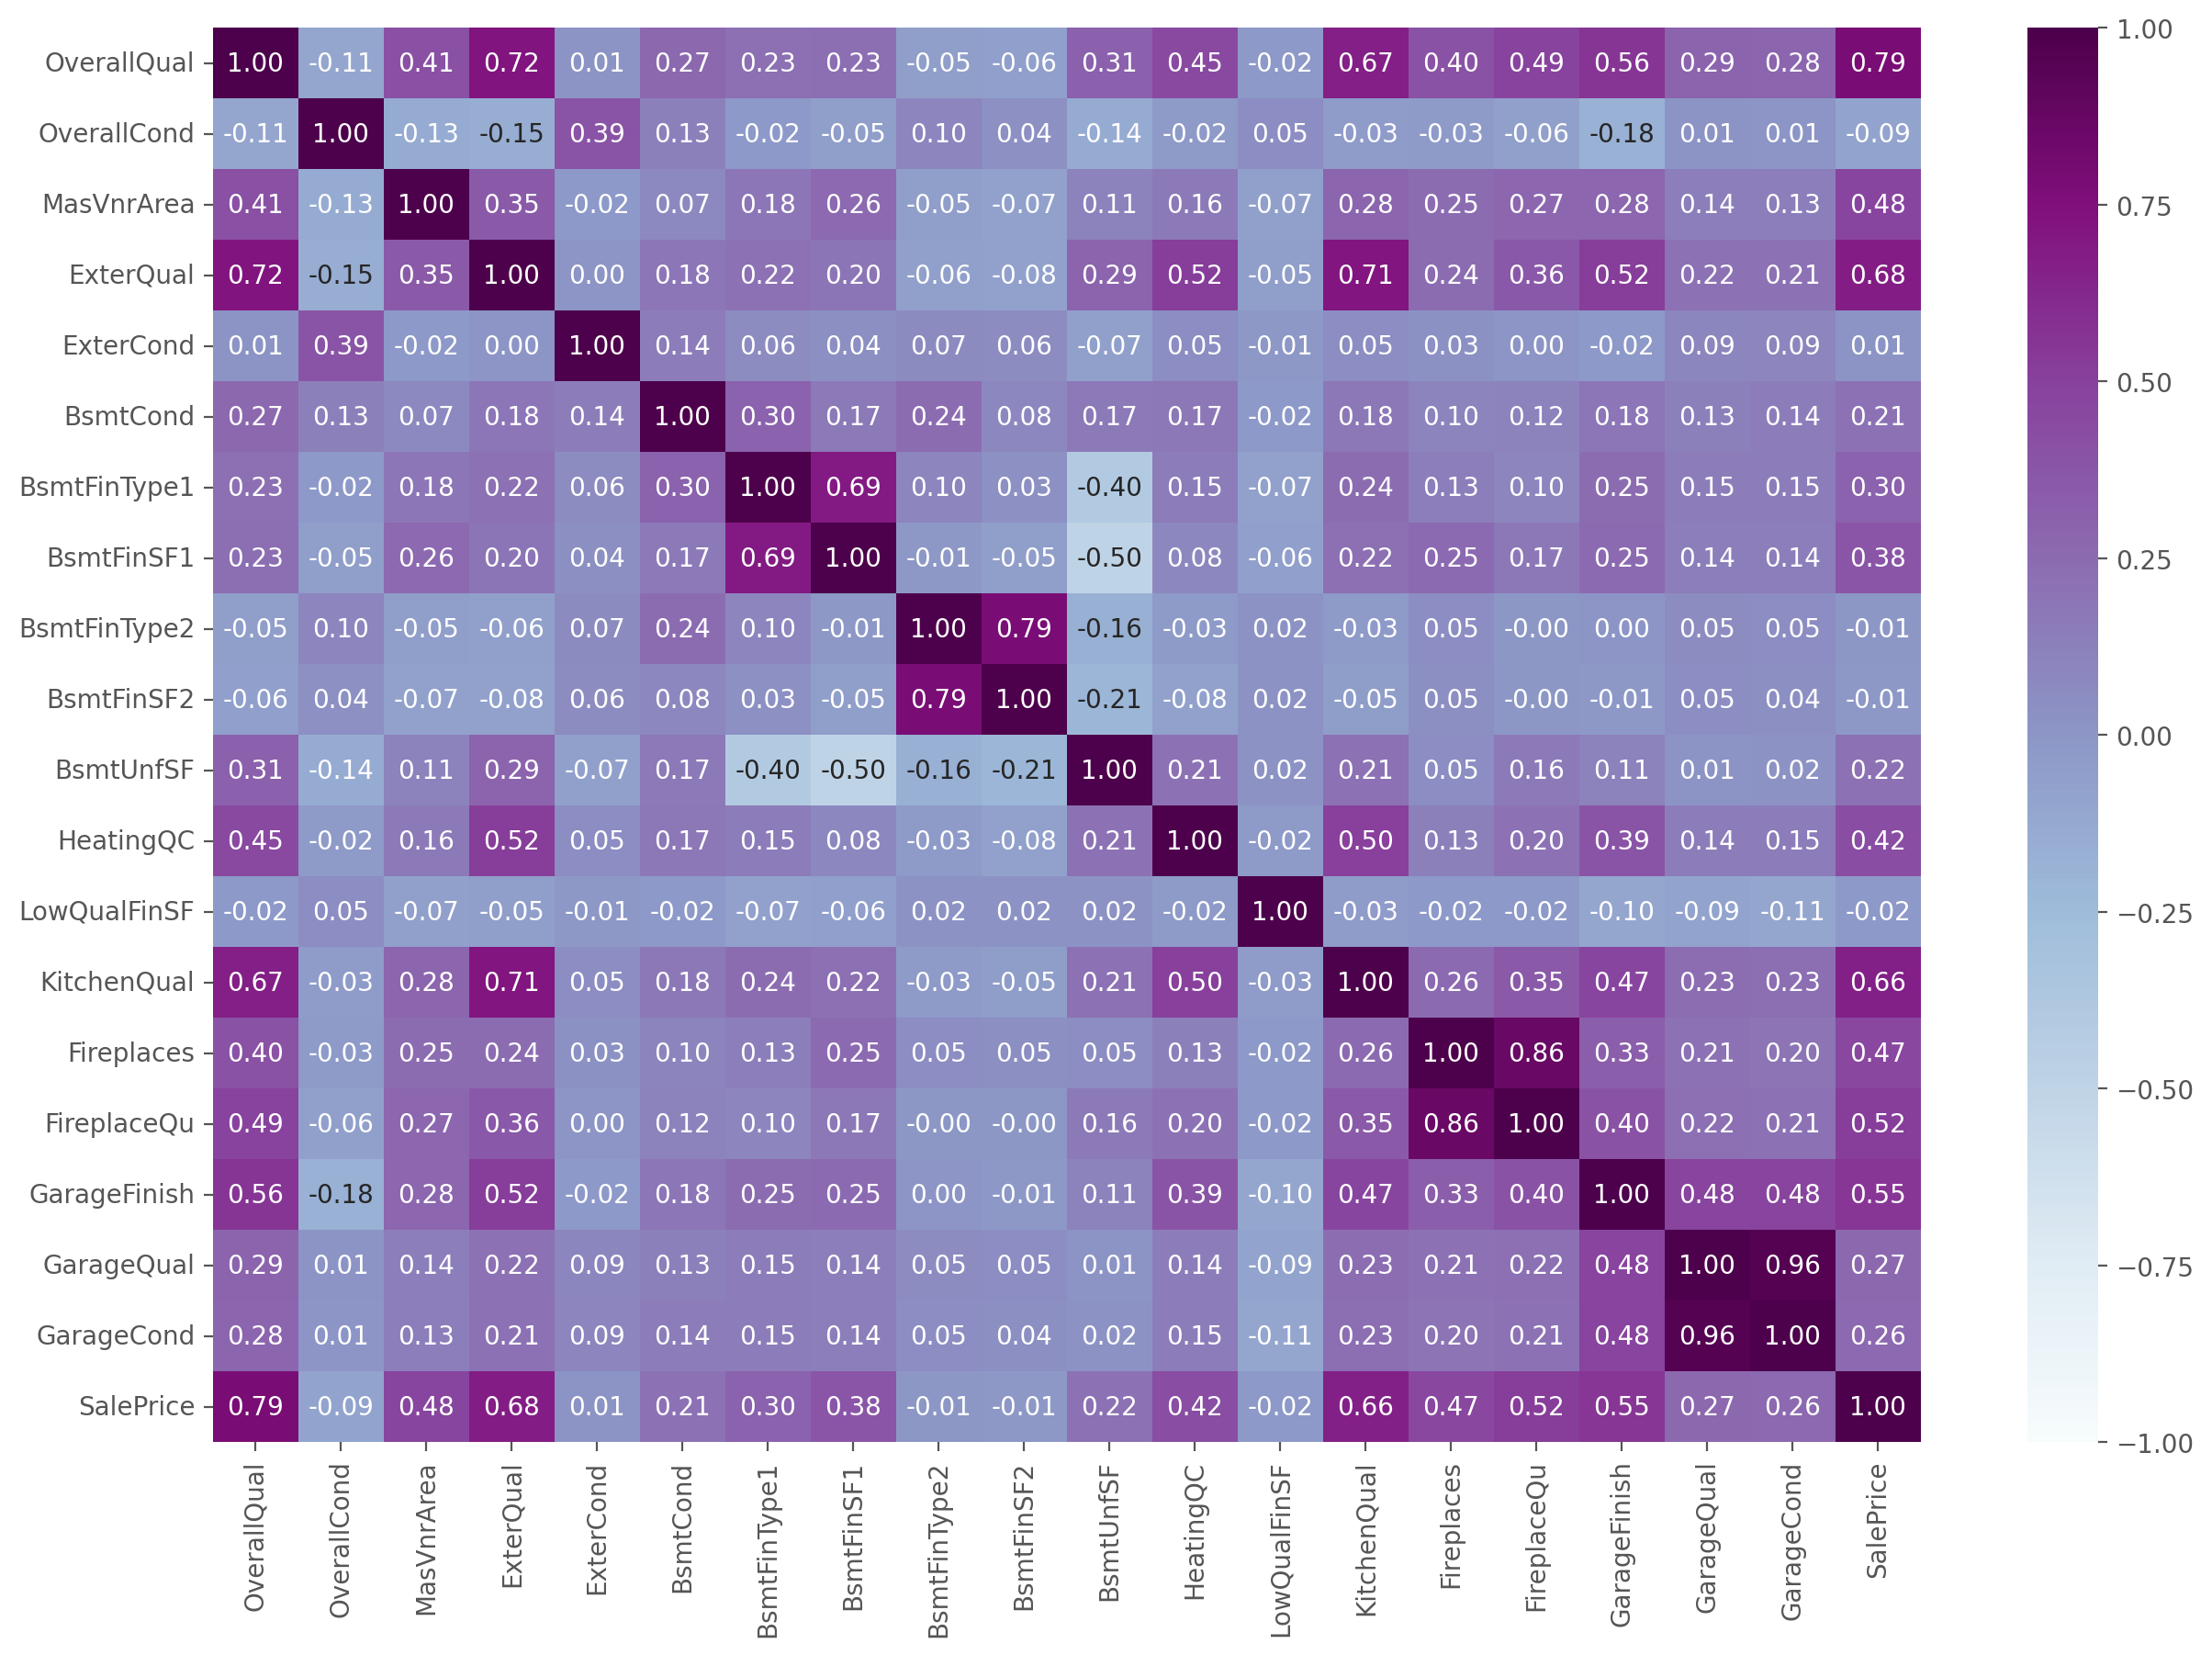

In [3056]:
# Create a correlation heat map for the rennovatable variables
corr_ren = house_r.corr()

# plot a heat map of the correlation coefficients
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(corr_ren, cmap="BuPu", 
            annot = True, annot_kws= {'size' : 10}, fmt=".2f", 
            vmin = -1, vmax = 1, ax = ax)
plt.show()

In [3057]:
# Look at which values at most highly correlated with saleprice
for a,b in corr_ren.items():
    if a == 'SalePrice':
        corr = pd.DataFrame({'variable':b.index, 'correlation':b.values})

corr['abs_corr'] = corr['correlation'].apply(lambda x: abs(x))        
corr.sort_values(by = 'abs_corr', ascending = False, inplace = True)
corr.reset_index(drop=True)

variable  correlation  abs_corr
0      SalePrice     1.000000  1.000000
1    OverallQual     0.788115  0.788115
2      ExterQual     0.679500  0.679500
3    KitchenQual     0.656493  0.656493
4   GarageFinish     0.548367  0.548367
5    FireplaceQu     0.517899  0.517899
6     MasVnrArea     0.475940  0.475940
7     Fireplaces     0.465300  0.465300
8      HeatingQC     0.423233  0.423233
9     BsmtFinSF1     0.382031  0.382031
10  BsmtFinType1     0.299437  0.299437
11    GarageQual     0.272647  0.272647
12    GarageCond     0.260135  0.260135
13     BsmtUnfSF     0.217400  0.217400
14      BsmtCond     0.209678  0.209678
15   OverallCond    -0.087662  0.087662
16  LowQualFinSF    -0.018405  0.018405
17     ExterCond     0.014822  0.014822
18    BsmtFinSF2    -0.013132  0.013132
19  BsmtFinType2    -0.006939  0.006939

In [3058]:
# Look for colinearity among other variables
# Look at which values at most highly correlated with saleprice
feature1 = []
feature2 = []
corr = []
for a,b in corr_ren.items():
    for x,y in b.items():
        if a != x:
            if abs(y) > 0.4:
                corr.append(round(abs(y),4))
                feature1.append(a)
                feature2.append(x)
highest_corr = pd.DataFrame({'feature_1': feature1, 'feature_2': feature2, 'correlation_abs' : corr})
highest_corr.drop_duplicates(subset='correlation_abs', inplace = True)
highest_corr.sort_values(by='correlation_abs',ascending = False).reset_index(drop=True)


feature_1     feature_2  correlation_abs
0     GarageQual    GarageCond           0.9589
1     Fireplaces   FireplaceQu           0.8632
2   BsmtFinType2    BsmtFinSF2           0.7888
3    OverallQual     SalePrice           0.7881
4    OverallQual     ExterQual           0.7238
5      ExterQual   KitchenQual           0.7132
6   BsmtFinType1    BsmtFinSF1           0.6949
7      ExterQual     SalePrice           0.6795
8    OverallQual   KitchenQual           0.6714
9    KitchenQual     SalePrice           0.6565
10   OverallQual  GarageFinish           0.5579
11  GarageFinish     SalePrice           0.5484
12   FireplaceQu     SalePrice           0.5179
13     ExterQual  GarageFinish           0.5172
14     ExterQual     HeatingQC           0.5170
15     HeatingQC   KitchenQual           0.5003
16    BsmtFinSF1     BsmtUnfSF           0.4960
17   OverallQual   FireplaceQu           0.4882
18  GarageFinish    GarageQual           0.4799
19  GarageFinish    GarageCond           0.4787
20    MasVnrArea     SalePrice           0.4759
21   KitchenQual  GarageFinish           0.4701
22    Fireplaces     SalePrice           0.4653
23   OverallQual     HeatingQC           0.4515
24     HeatingQC     SalePrice           0.4232
25   OverallQual    MasVnrArea           0.4103

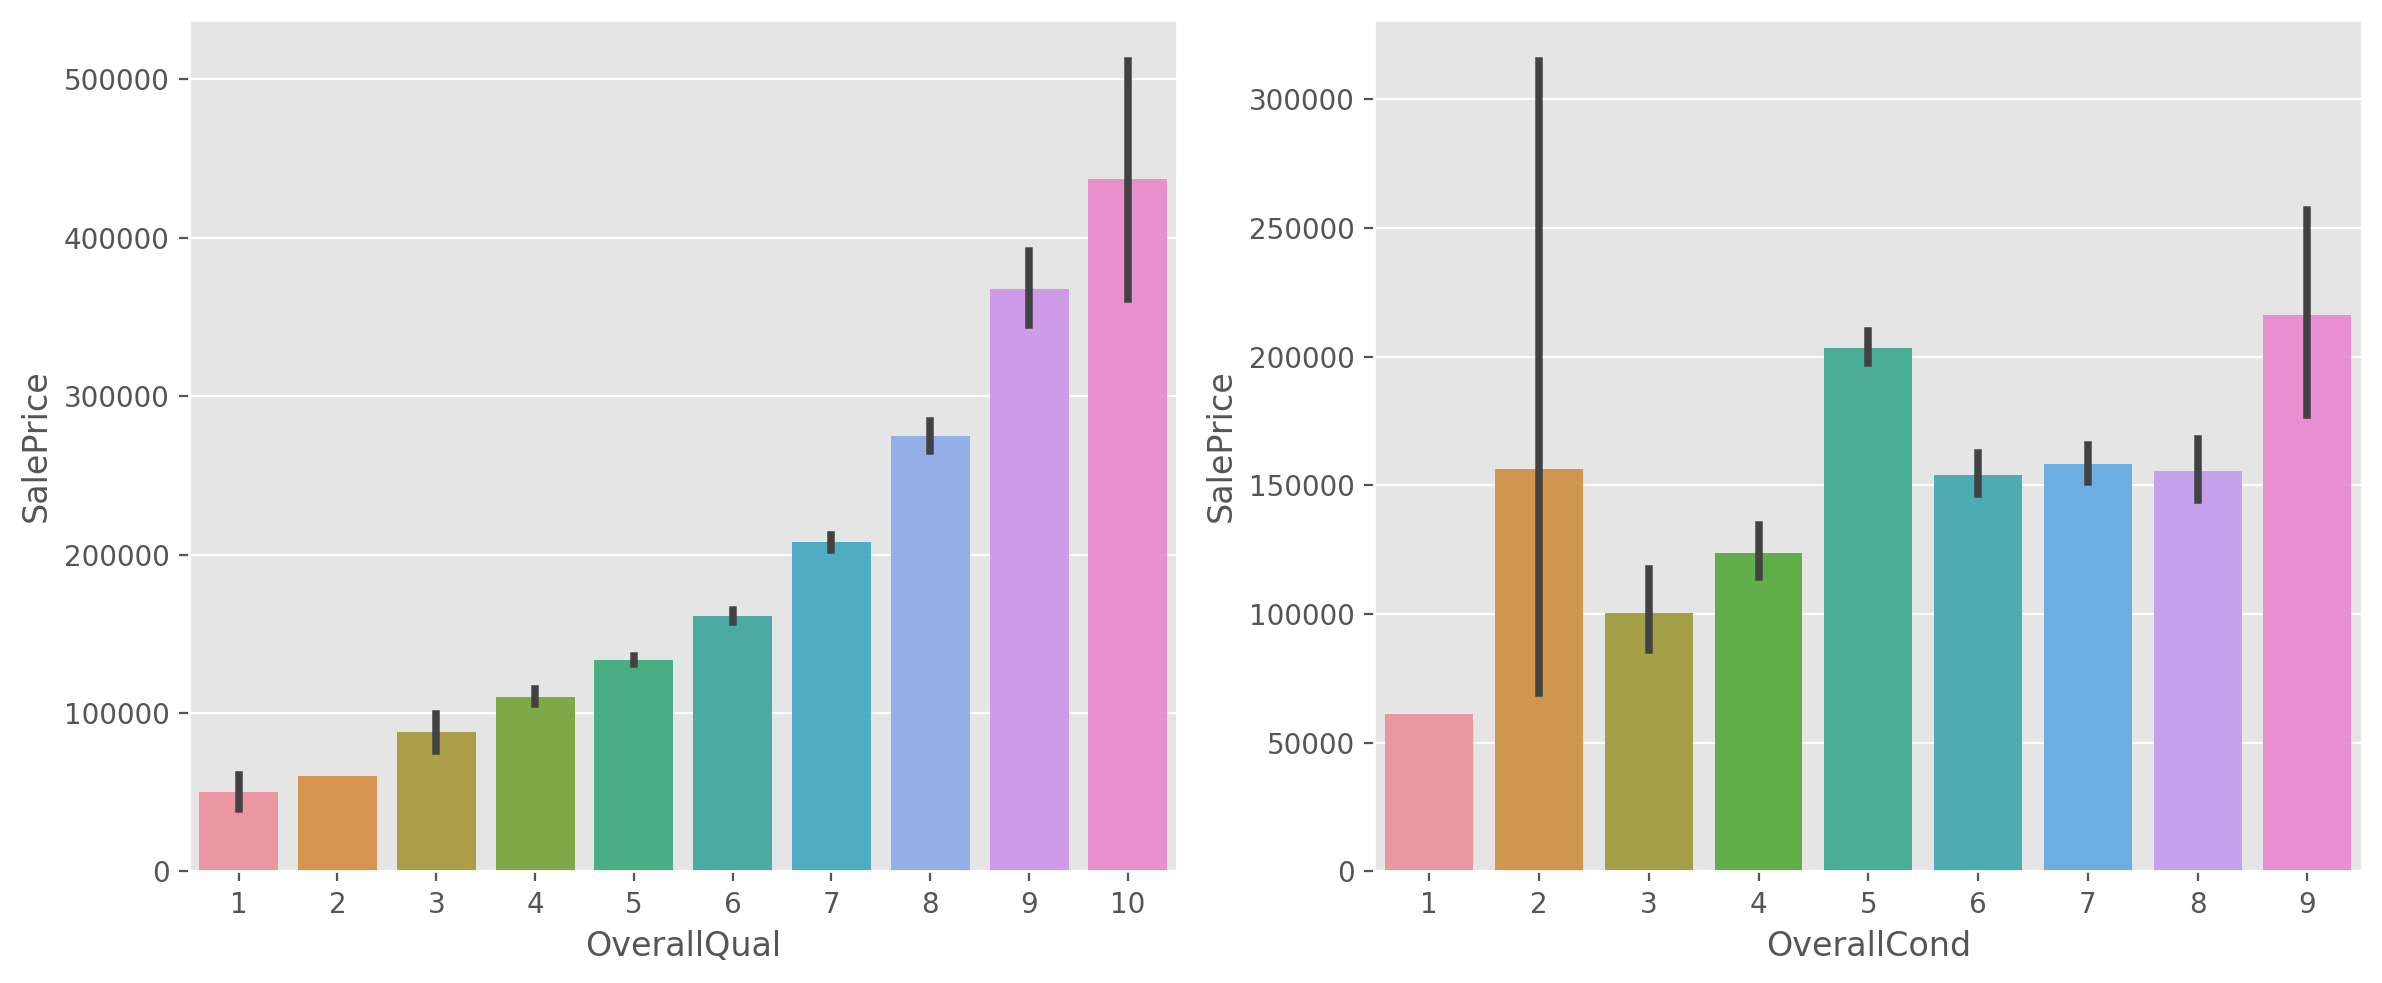

In [3060]:
# Plot the relationship between overall quality and house price
fig, ax = plt.subplots(ncols = 2, figsize = (12,5))
sns.barplot(data = house_r, x = 'OverallQual', y = 'SalePrice', ax=ax[0])
sns.barplot(data = house_r, x = 'OverallCond', y = 'SalePrice', ax = ax[1])
plt.tight_layout();

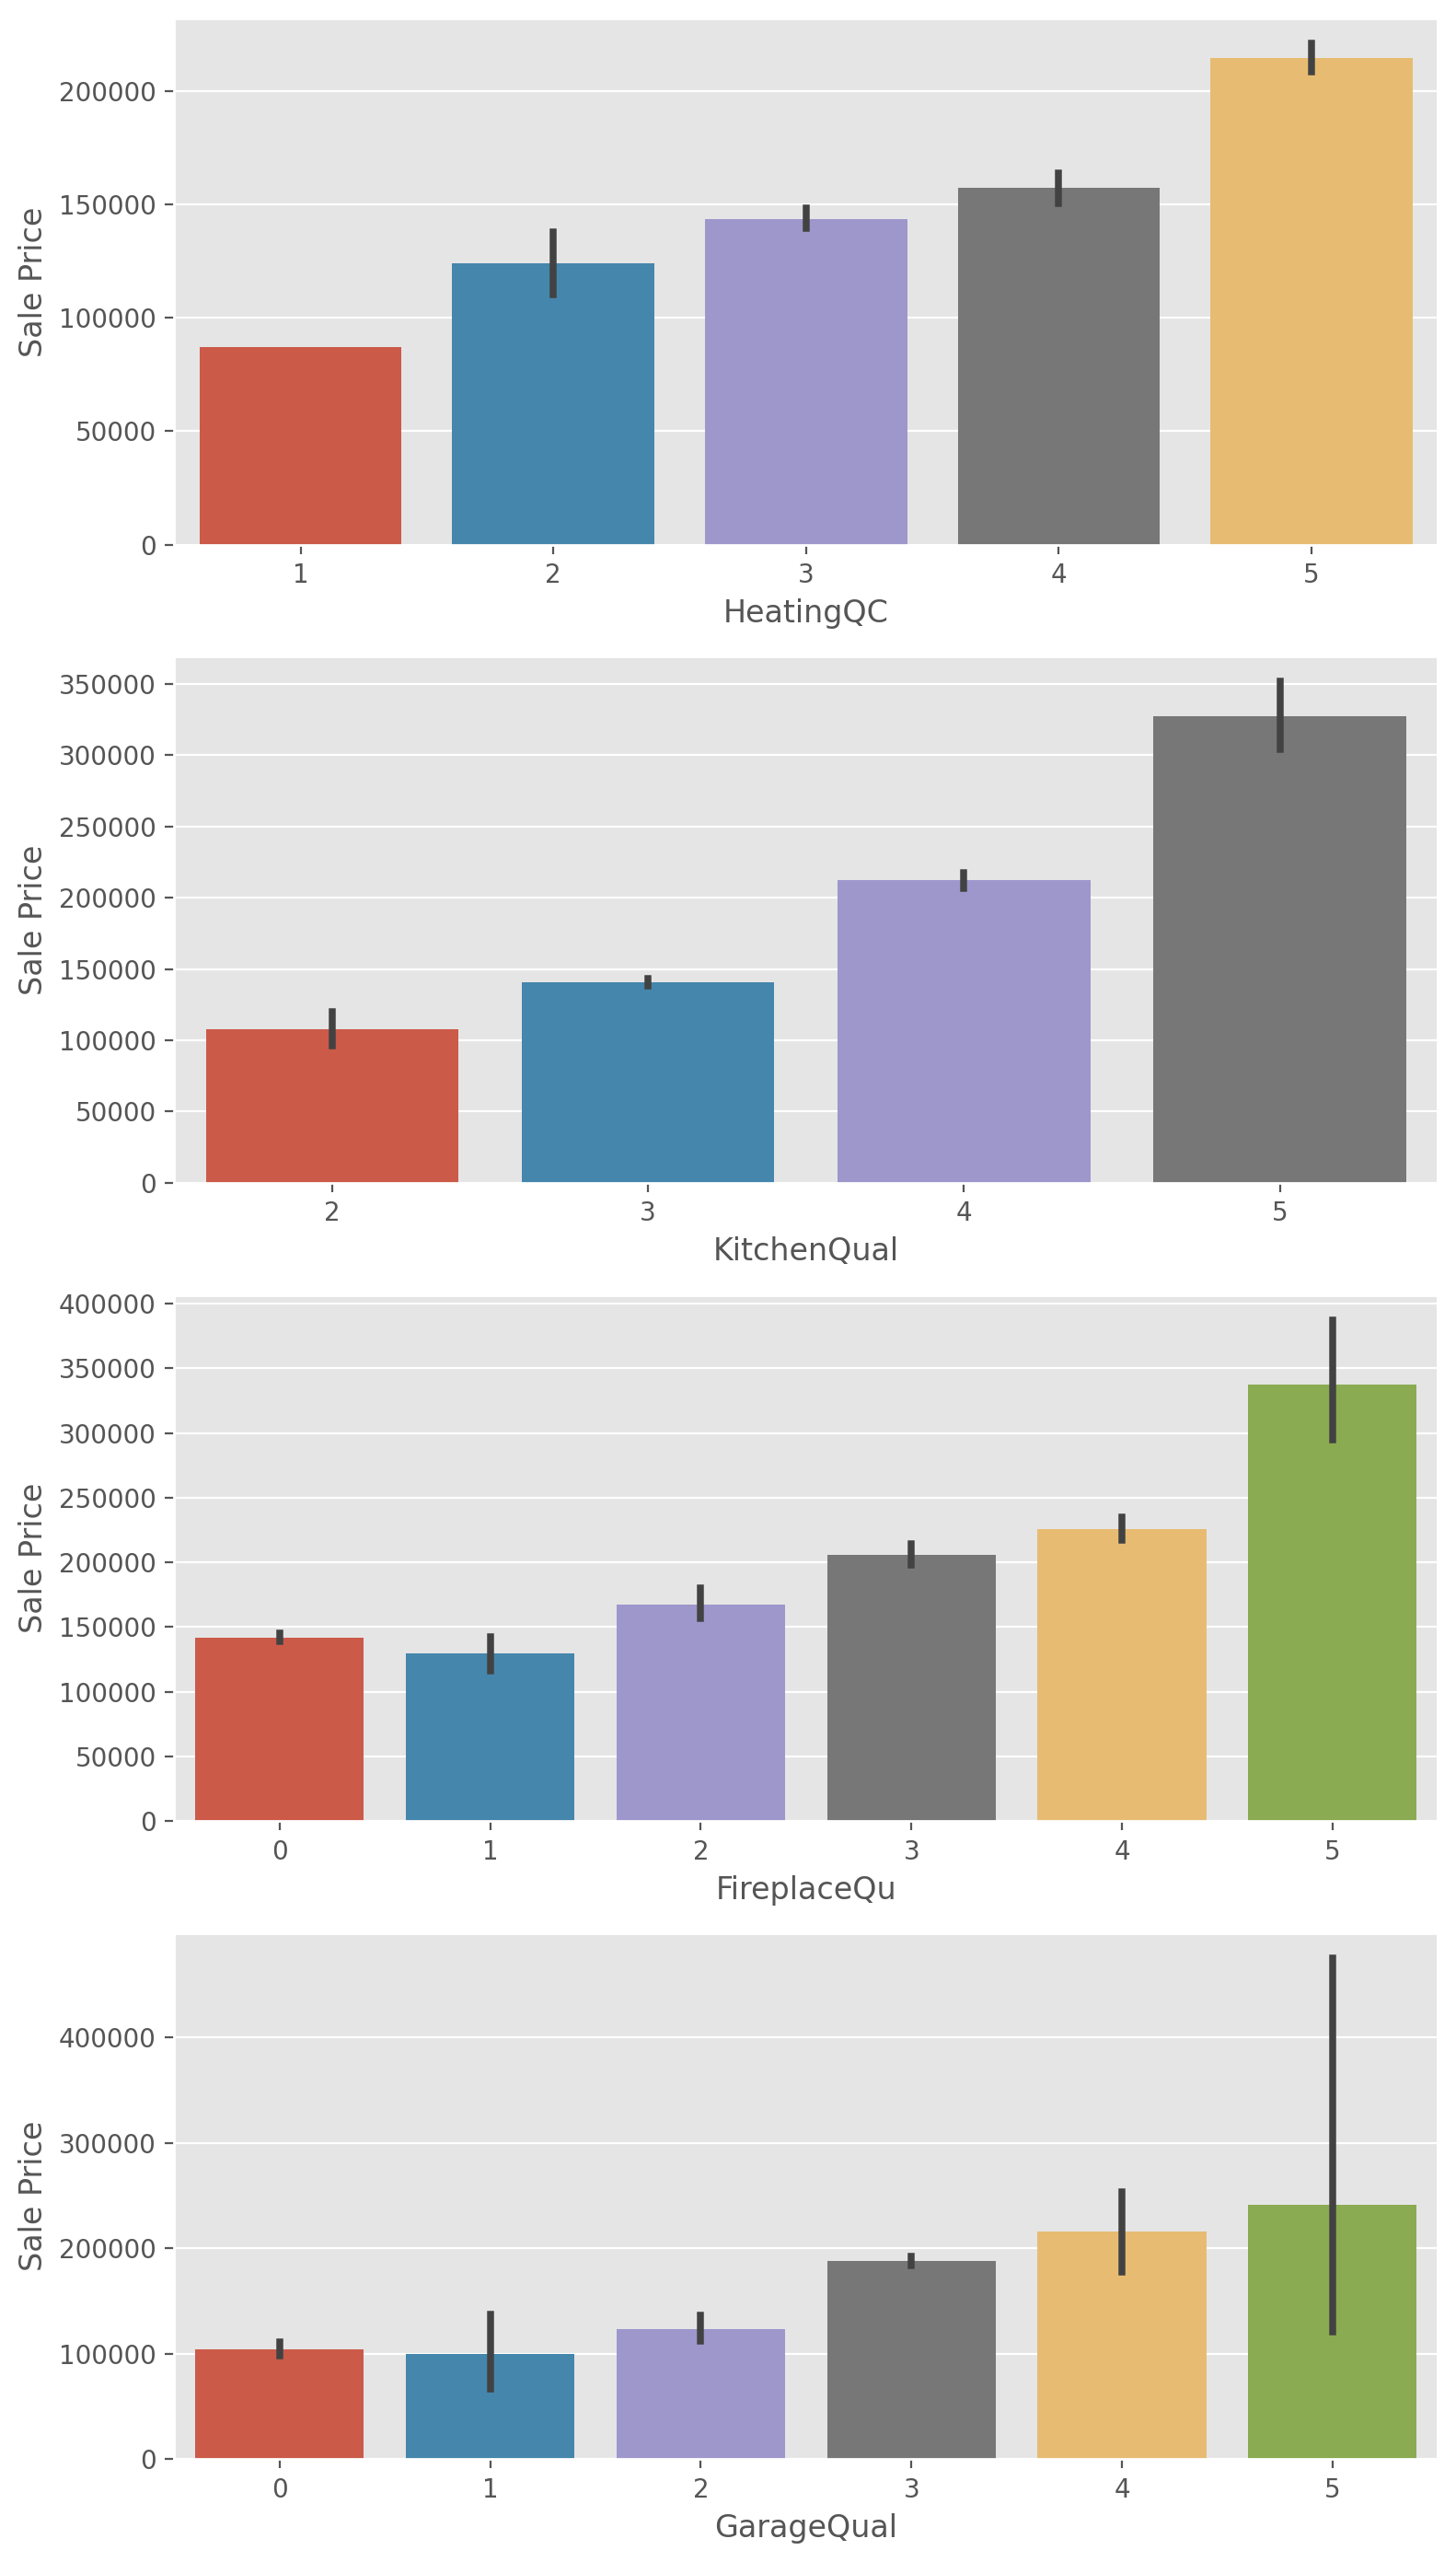

In [3061]:
# Create plots to compare the effect on saleprice of a non existent feature vs a low quality feature
quality = ['HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual']

fig,ax = plt.subplots(nrows = len(quality), figsize = (8,14))
for x in range(len(quality)):
    sns.barplot(data = house_r, x = quality[x], y = 'SalePrice', ax=ax[x])
    ax[x].set_xlabel(quality[x])
    ax[x].set_ylabel('Sale Price')
plt.tight_layout()
plt.show()

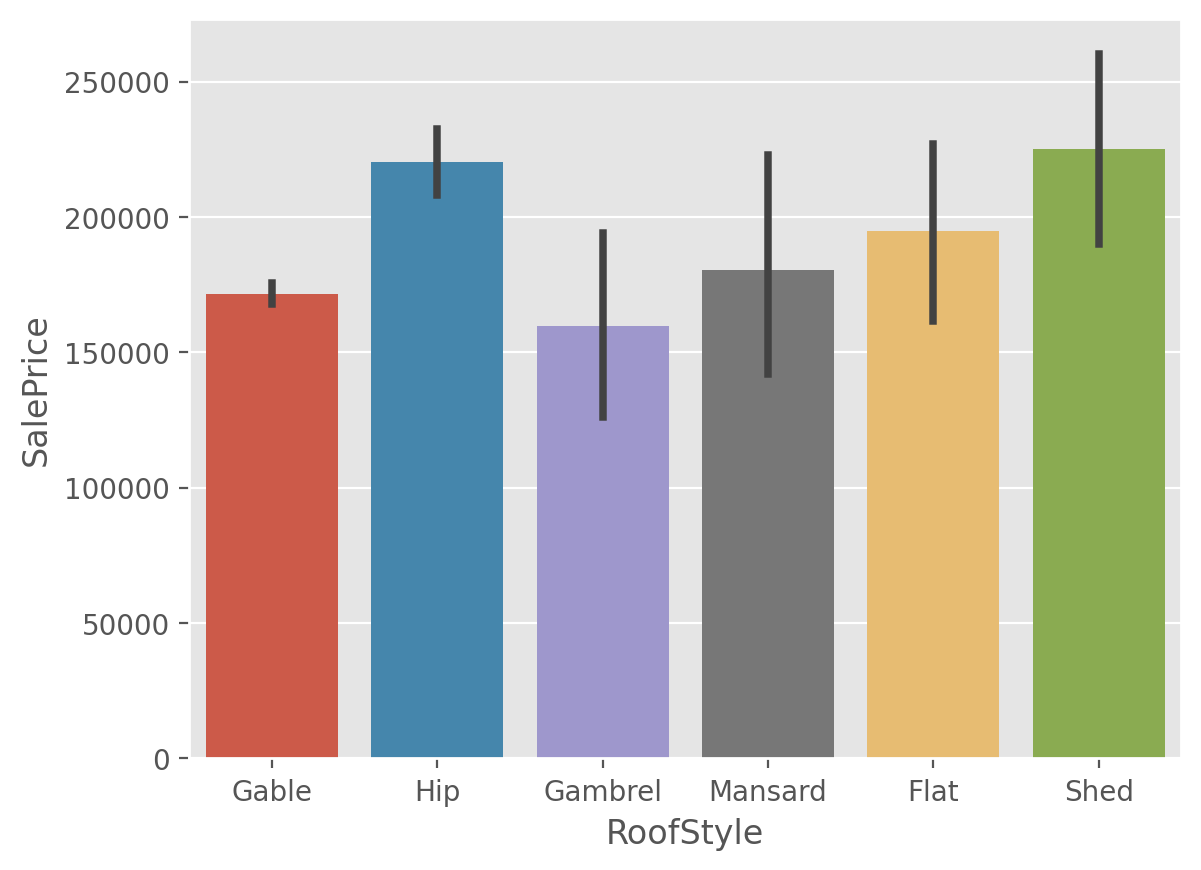

In [3062]:
# look at the median sale price per roofstyle
sns.barplot(data = house_r, x = 'RoofStyle', y = 'SalePrice');

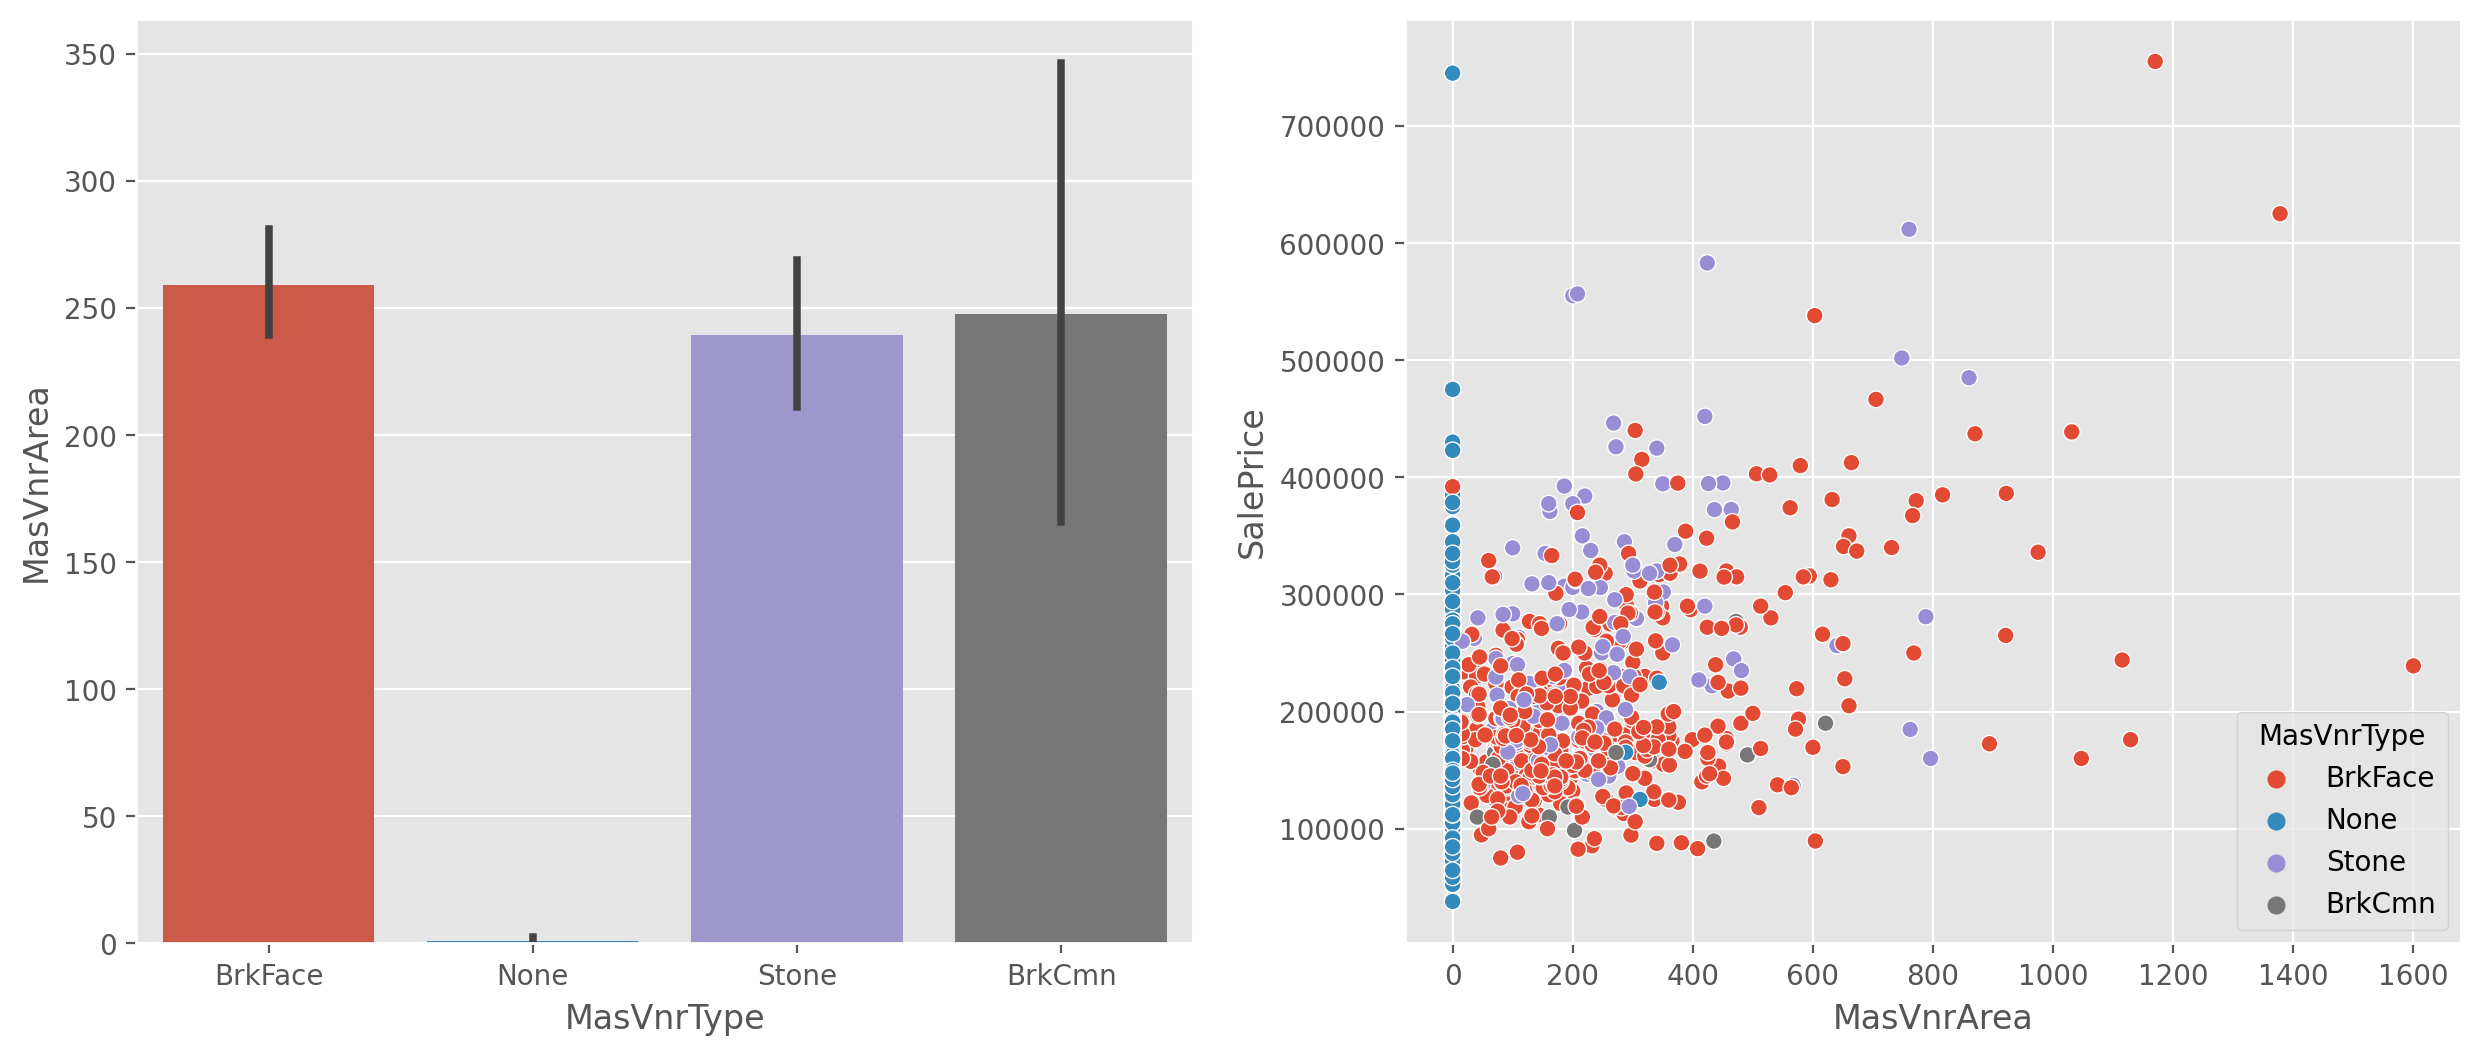

In [3063]:
# plot MasVnrType vs MasVnrArea
fig, ax = plt.subplots(ncols = 2, figsize = (15,6))
sns.barplot(data = house_r, x = 'MasVnrType', y ='MasVnrArea', ax = ax[0])
sns.scatterplot(data = house_r, x = 'MasVnrArea', y = 'SalePrice', hue = 'MasVnrType', ax = ax[1])
plt.show()

In [3064]:
# categorize the variables
nominal_r = ['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Heating', 'CentralAir', 
            'Electrical', 'Functional', 'PavedDrive', 'Fence']
ordinal_r = ['OverallQual', 'OverallCond','ExterQual', 'ExterCond', 'BsmtCond',
            'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 
             'GarageQual', 'GarageCond']
numerical_r = [x for x in house_r.columns if x not in nominal_r and x not in ordinal_r]

### Observations from correlation
**Most highly correlated variables with Saleprice:**
- OverallQual
- ExterQual
- KitchenQual

**Colinear variables**
- OverallQual is highly correlated with a lot of the other variables - this makes sense as a lot of the other variables are also measures of quality
There is also a lot of colinearity between other quality features (makes sense that if one feature in the house is of higher quality, the rest are likely to be of the same quality)

Also between variables which relate to the same feature
- GarageQual and GarageCond
- FireplaceQC and Fireplaces
- BsmtFinType2 and BsmtFinSF2 (same for type 1 and SF1)
- GarageFinish and GarageQual
- GarageFinish and GarageCond

**From plotting**
We can see that a house with a low quality feature (e.g. garage) does not have a higher average price than houses without that feature. As the quality increases so does the price. Can conclude that increasing quality/making rennovations does have an effect on house price. This can also be seen from the plot of overall quality against sale price. As the overall quality increases, this has a huge effect on saleprice.

Alternatively the overall condition does not seem strongly related to houseprice

In [3065]:
# add year sold so that we can separate our test and train sets
house_r['YrSold'] = house['YrSold']

In [3066]:
# Drop colinear variables
# Drop all but one variables that relate to the same feature 
X = house_r.copy()
X.drop(['OverallCond','GarageCond', 'GarageQual', 'FireplaceQu', 'BsmtFinSF1', 'BsmtFinSF2',
        'MasVnrArea'], axis = 1, inplace = True)

In [3067]:
# dummify the categorical variables
X = pd.get_dummies(X, columns = [x for x in X.columns if x in nominal_r], drop_first = True)


In [3068]:
# create train and test sets
X_train_qual = X[X['YrSold'] < 2010].copy()
y_train_qual = X_train_qual.pop('SalePrice')

X_test_qual = X[X['YrSold'] == 2010].copy()
y_test_qual = X_test_qual.pop('SalePrice')

# drop year sold - this is not a 'rennovatable feature'
X_train_qual.drop('YrSold', axis = 1, inplace = True)
X_test_qual.drop('YrSold', axis = 1, inplace = True)

In [3069]:
# instatiate model
model = LinearRegression()
# evaluate the model
linear_regression(model, X_train_qual, y_train_qual, X_test_qual, y_test_qual)

LR results
cross validation mean    0.679743
training score           0.741465
test_score               0.722277

In [3070]:
# Elasticnet regression
# Create an ElasticnetCV model instance 
optimal_enet = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 25), n_alphas=100, cv=10)
                        
# fit the model
optimal_enet.fit(X_train_qual, y_train_qual)

# get the best alpha and l1 ration
optimal_enet_alpha = optimal_enet.alpha_
optimal_l1_ratio = optimal_enet.l1_ratio_

#   evaluate the model on the training set
enet_train = optimal_enet.score(X_train_qual, y_train_qual)
    
#   evaluate on the test set
enet_test = optimal_enet.score(X_test_qual, y_test_qual)

# Display results
print('Optimal alpha:', optimal_enet_alpha, '\nOptimal l1 ratio:', optimal_l1_ratio)
print('Elastic net train score:', enet_train, 'Elastic net test score:', enet_test) 

Optimal alpha: 7798.766117931672 
Optimal l1 ratio: 1.0
Elastic net train score: 0.6482474033516092 Elastic net test score: 0.62920591181248


In [3071]:
# look at the coefficients from elasticnet 
coef_qual = pd.DataFrame(list(zip(X_train_qual.columns, optimal_enet.coef_)), columns = ['variable','coefficient'])
coef_qual['abs'] = abs(coef_qual['coefficient'])
coef_qual[coef_qual['coefficient'] != 0].sort_values(by = 'abs', ascending = False)

variable   coefficient           abs
0    OverallQual  36571.322664  36571.322664
4   BsmtFinType1   4536.145267   4536.145267
10    Fireplaces   3198.563005   3198.563005
11  GarageFinish   2819.293238   2819.293238
9    KitchenQual   1073.010324   1073.010324
6      BsmtUnfSF     10.248687     10.248687
8   LowQualFinSF      1.203646      1.203646

In [3072]:
# we now want to use this model to predict whether the rennovations can predict the unexplained variance from part 1
# Train and evaluate the model using the residuals from the previous model
y_train_qual = df_train['residuals']
y_test_qual = df_test['residuals']

In [3073]:
linear_regression(model, X_train_qual, y_train_qual, X_test_qual, y_test_qual)

LR results
cross validation mean   -0.572371
training score           0.295672
test_score               0.093445

In [3074]:
# Create an ElasticnetCV model instance 
optimal_enet = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 25), n_alphas=100, cv=10)
                        
# fit the model
optimal_enet.fit(X_train_qual, y_train_qual)

# get the best alpha and l1 ration
optimal_enet_alpha = optimal_enet.alpha_
optimal_l1_ratio = optimal_enet.l1_ratio_

#   evaluate the model on the training set
enet_train = optimal_enet.score(X_train_qual, y_train_qual)
    
#   evaluate on the test set
enet_test = optimal_enet.score(X_test_qual, y_test_qual)

# Display results
print('Optimal alpha:', optimal_enet_alpha, '\nOptimal l1 ratio:', optimal_l1_ratio)
print('Elastic net train score:', enet_train, 'Elastic net test score:', enet_test) 

Optimal alpha: 441.3311649232593 
Optimal l1 ratio: 1.0
Elastic net train score: 0.09313983172051132 Elastic net test score: 0.09830011123350879


In [2980]:
coef_qual = pd.DataFrame(list(zip(X_train_qual.columns, optimal_enet.coef_)), columns = ['variable','coefficient'])
coef_qual['abs'] = abs(coef_qual['coefficient'])
coef_qual[coef_qual['coefficient'] != 0].sort_values(by = 'abs', ascending = False)

variable   coefficient           abs
71       Functional_Typ  10685.264894  10685.264894
0           OverallQual   5017.297124   5017.297124
26  Exterior1st_BrkFace   3981.178136   3981.178136
3              BsmtCond  -3324.037141   3324.037141
9           KitchenQual   2848.750944   2848.750944
12      RoofStyle_Gable  -2166.618648   2166.618648
11         GarageFinish  -2037.174373   2037.174373
35  Exterior1st_VinylSd  -2016.664851   2016.664851
54      MasVnrType_None   1650.182941   1650.182941
14        RoofStyle_Hip   1624.787488   1624.787488
7             HeatingQC    480.030033    480.030033
8          LowQualFinSF    -33.902107     33.902107
6             BsmtUnfSF     -6.817171      6.817171

## Conclusions
Using the quality variables we can predict the sale price fairly well however, creating a model using the residuals from the previous section does not predict these residuals very well at all. This could be due to the fact that some of the largest residuals are for the houses at the very expensive end of the scale. Perhaps increasing the quality/rennovations is not increasing the cost of more expensive houses significantly more than less expensive ones.

I would not use this model as a prediction of what houses to buy and rennovate as we cannot use it to explain the variance in our first model. However, even if the model was giving good scores, it does not account for the cost of rennovation vs the increase in price. Therefore I would not trust it implicitly without factoring cost of rennovations.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [5]:
# A: